# Iyzico Member Businesses' Expected Transaction Volume Estimation Study

Iyzico that makes the online shopping experience easier for both buyers and sellers is a financial technology company. Iyzico provides payment infrastructure for E-commerce companies, marketplaces, and individual users. It is expected that the total transaction volume will be estimated on a merchant_id and daily basis for the last 3 months of 2020.

## Variables:

* **transaction_date**: Date of sales data
* **merchant_id**: IDs of member businesses (unique number for each member business)
* **Total_Transaction**: Number of transactions
* **Total_Paid**: Payment amount

In [2]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f'% x)
warnings.filterwarnings("ignore")

## 1. Loading The Data

In [4]:
df = pd.read_csv("iyzico_data.csv", parse_dates=["transaction_date"])
df.head()

Unnamed: 0 transaction_date  merchant_id  Total_Transaction  Total_Paid
0           0       2018-01-01          535                349   25883.226
1           1       2018-01-01        42616                141   40918.860
2           2       2018-01-01        46774                410  306902.700
3           3       2018-01-01        86302                 10      11.340
4           4       2018-01-01       124381                285  111383.766

In [5]:
df.tail()

Unnamed: 0 transaction_date  merchant_id  Total_Transaction  Total_Paid
7662        7662       2020-12-31        46774               3394 3174751.332
7663        7663       2020-12-31        57192                856  337696.020
7664        7664       2020-12-31        86302               2657   10461.006
7665        7665       2020-12-31       124381               3668 2445655.950
7666        7666       2020-12-31       129316                485    2101.050

In [6]:
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid
0       2018-01-01          535                349   25883.226
1       2018-01-01        42616                141   40918.860
2       2018-01-01        46774                410  306902.700
3       2018-01-01        86302                 10      11.340
4       2018-01-01       124381                285  111383.766

In [7]:
df["transaction_date"].dtypes

dtype('<M8[ns]')

## 2. Exploratory Data Analysis

In [14]:
## check function:

def check_df(dataframe, head=5):
    print("############ Shape ############")
    print(dataframe.shape)
    print("############ Types ############")
    print(dataframe.dtypes)
    print("############ Head ############")
    print(dataframe.head(head))
    print("############ Tail ############")
    print(dataframe.tail(head))
    print("############ NA ############")
    print(dataframe.isnull().sum())
    print("############ Quantiles ############")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [16]:
# max and min date in data set:

df["transaction_date"].min(), df["transaction_date"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [18]:
check_df(df)

############ Shape ############
(7667, 4)
############ Types ############
transaction_date     datetime64[ns]
merchant_id                   int64
Total_Transaction             int64
Total_Paid                  float64
dtype: object
############ Head ############
  transaction_date  merchant_id  Total_Transaction  Total_Paid
0       2018-01-01          535                349   25883.226
1       2018-01-01        42616                141   40918.860
2       2018-01-01        46774                410  306902.700
3       2018-01-01        86302                 10      11.340
4       2018-01-01       124381                285  111383.766
############ Tail ############
     transaction_date  merchant_id  Total_Transaction  Total_Paid
7662       2020-12-31        46774               3394 3174751.332
7663       2020-12-31        57192                856  337696.020
7664       2020-12-31        86302               2657   10461.006
7665       2020-12-31       124381               3668 2445655.95

In [20]:
# number of unique workplaces

df["merchant_id"].nunique()

7

In [22]:
df['merchant_id'].unique()

array([   535,  42616,  46774,  86302, 124381, 129316,  57192],
      dtype=int64)

In [24]:
# Total transaction volume by workplace:

df.groupby("merchant_id").agg({"Total_Transaction": "sum"}).sort_values(by="Total_Transaction", ascending=False)

Total_Transaction
merchant_id                   
124381                 1935357
46774                  1599559
535                    1302725
57192                  1146440
42616                  1126191
86302                   840951
129316                  440029

In [26]:
# Total paid volume by workplace:
df.groupby("merchant_id").agg({"Total_Paid": "sum"}).sort_values(by="Total_Paid", ascending=False)

Total_Paid
merchant_id               
46774       1567200341.286
124381      1158692543.973
42616        354583091.808
57192        317337137.586
535          156601530.234
86302          2870446.716
129316         1555471.476

In [28]:
# Transaction volume statistics of member businesses:
df.groupby("merchant_id").agg({"Total_Transaction": ["sum","mean","median","std"]})

Total_Transaction                           
                          sum     mean   median      std
merchant_id                                             
535                   1302725 1188.618 1029.500  498.633
42616                 1126191 1027.547  667.000 1780.256
46774                 1599559 1459.452 1313.500  844.590
57192                 1146440 1050.816 1073.000  215.101
86302                  840951  767.291  160.000 1127.962
124381                1935357 1765.837  816.500 2245.710
129316                 440029  401.486  383.000  210.783

Let's visualize the transaction volume numbers on a yearly basis:

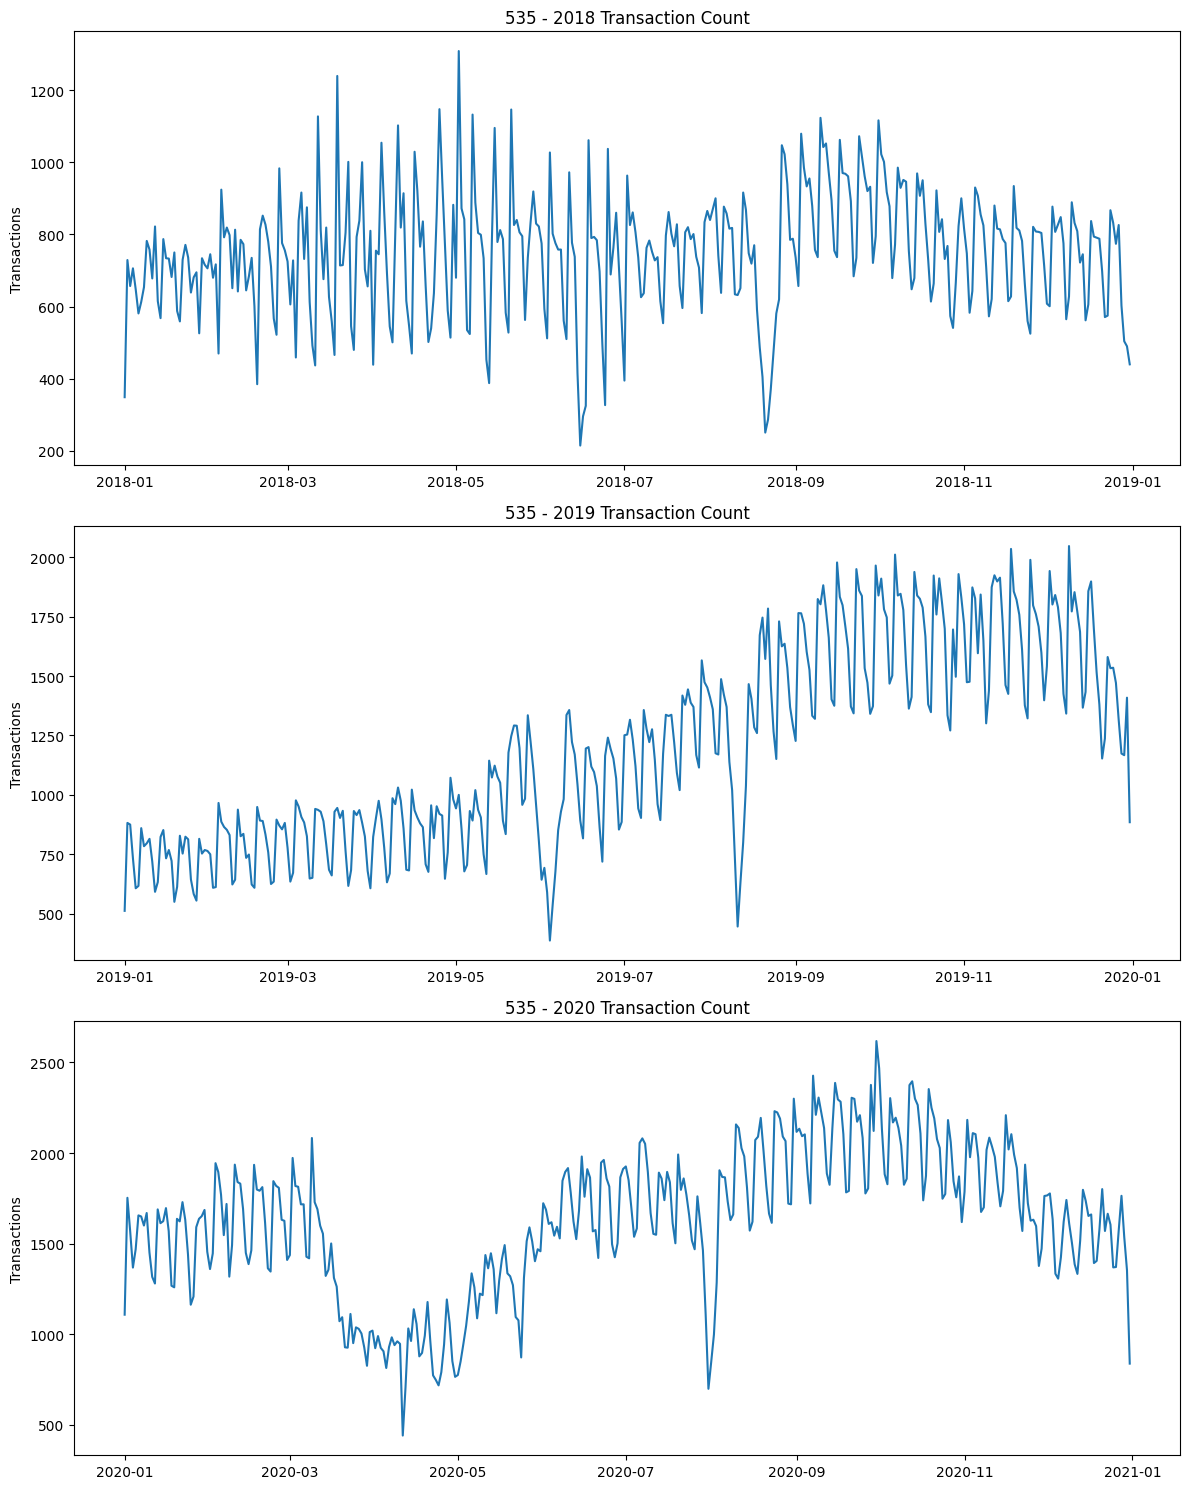

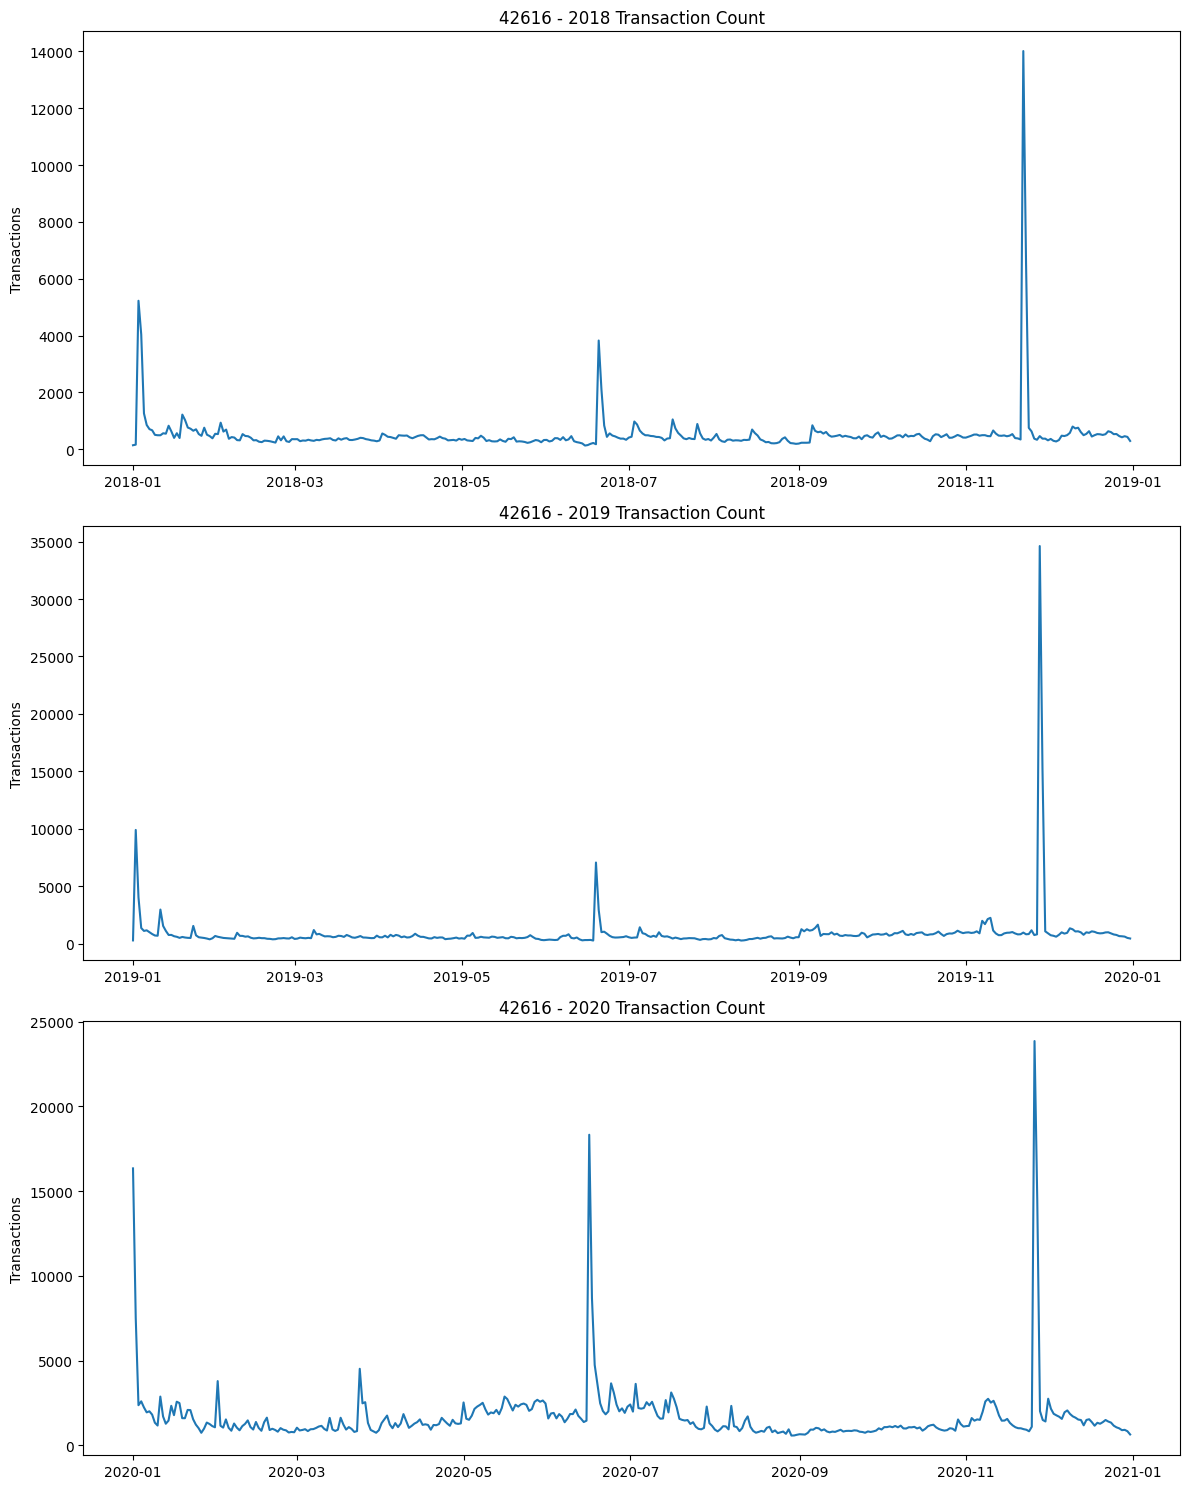

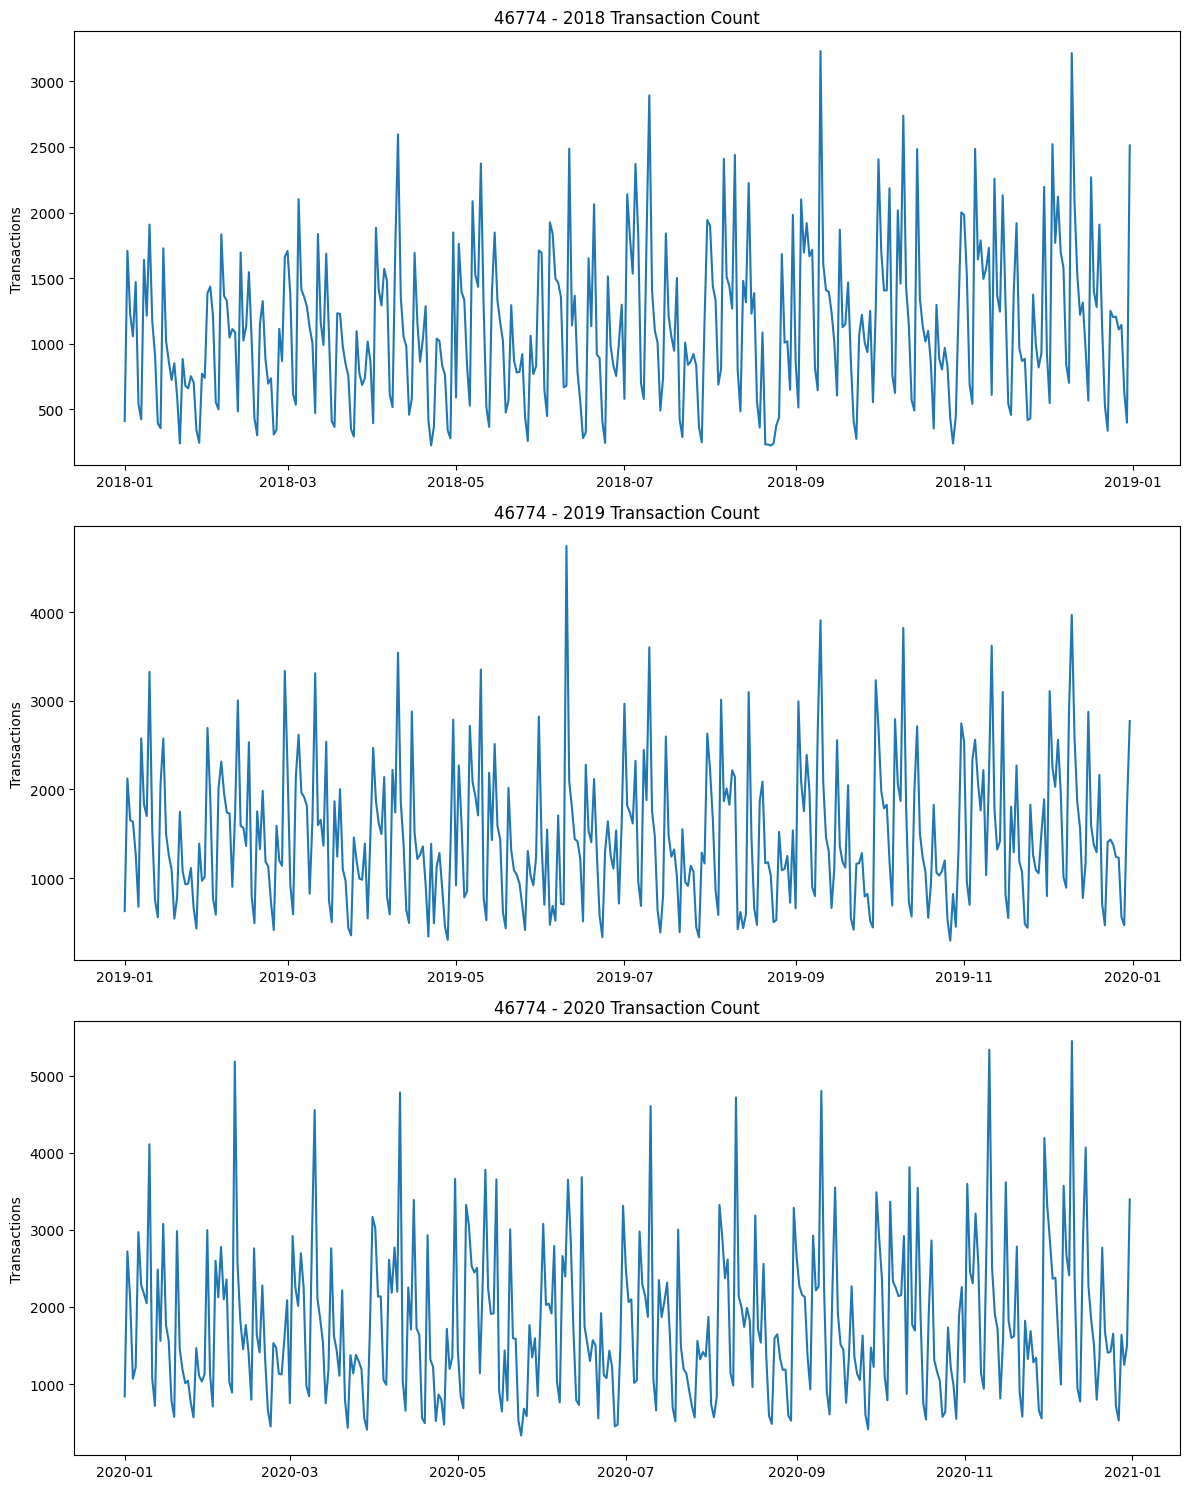

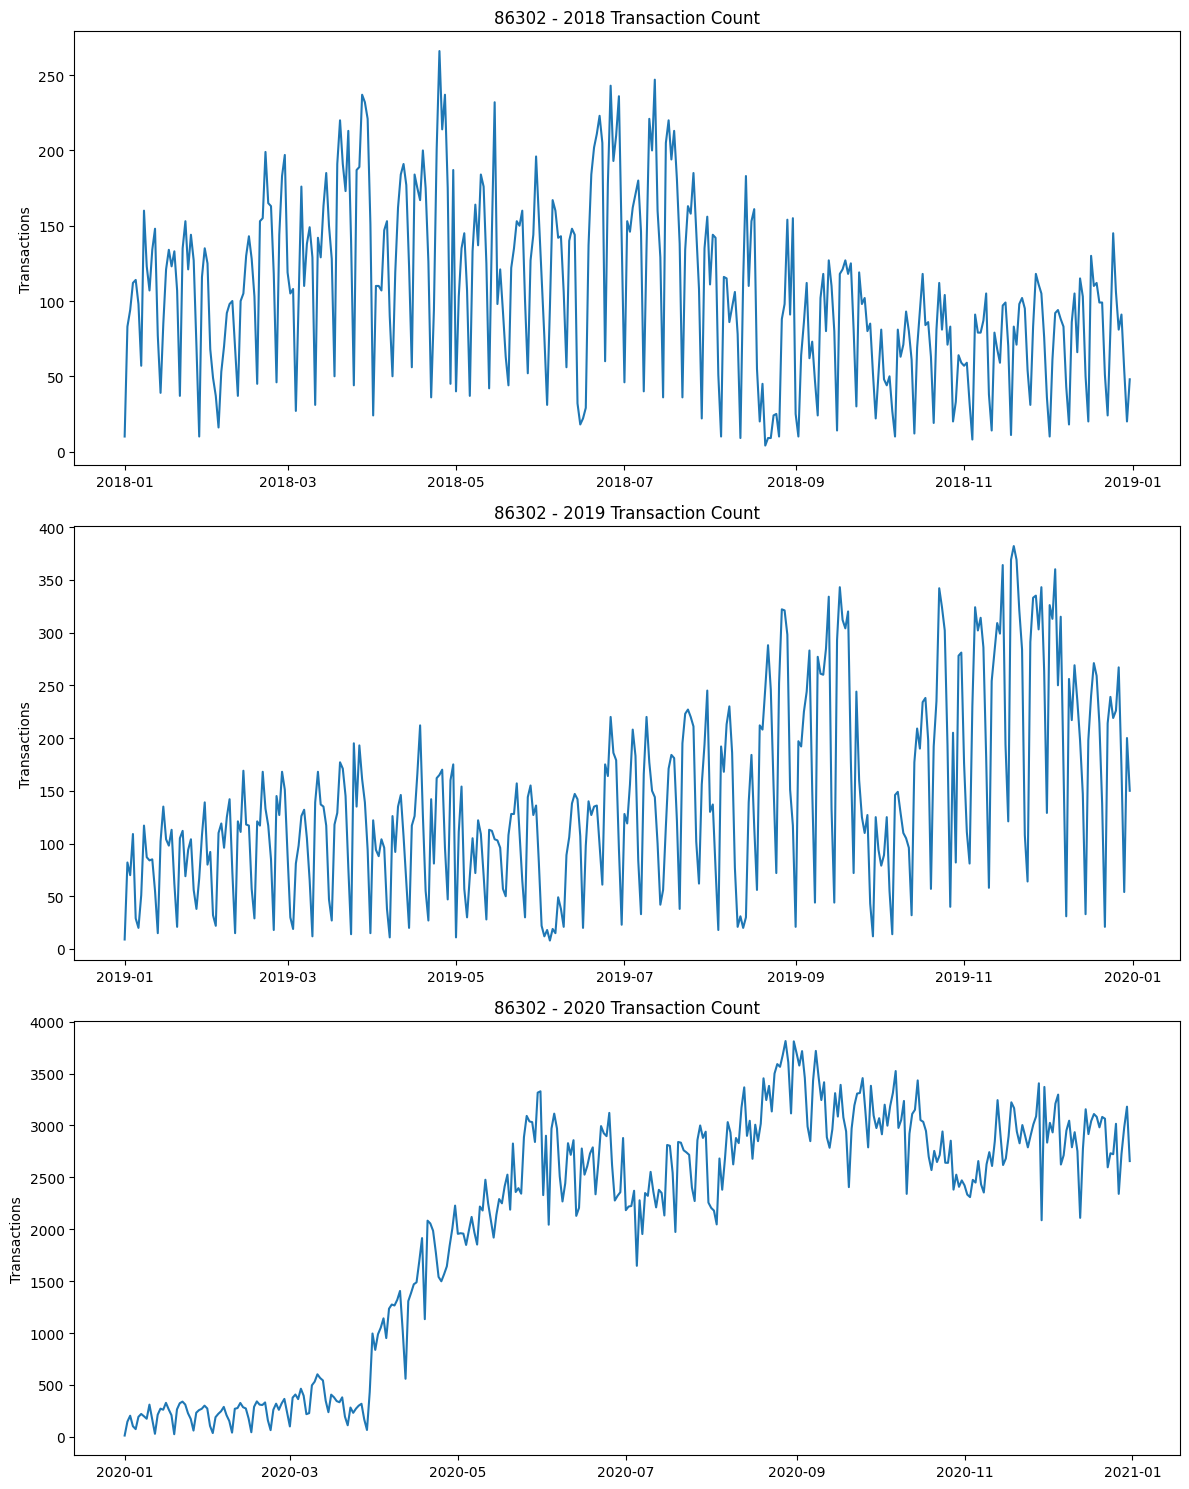

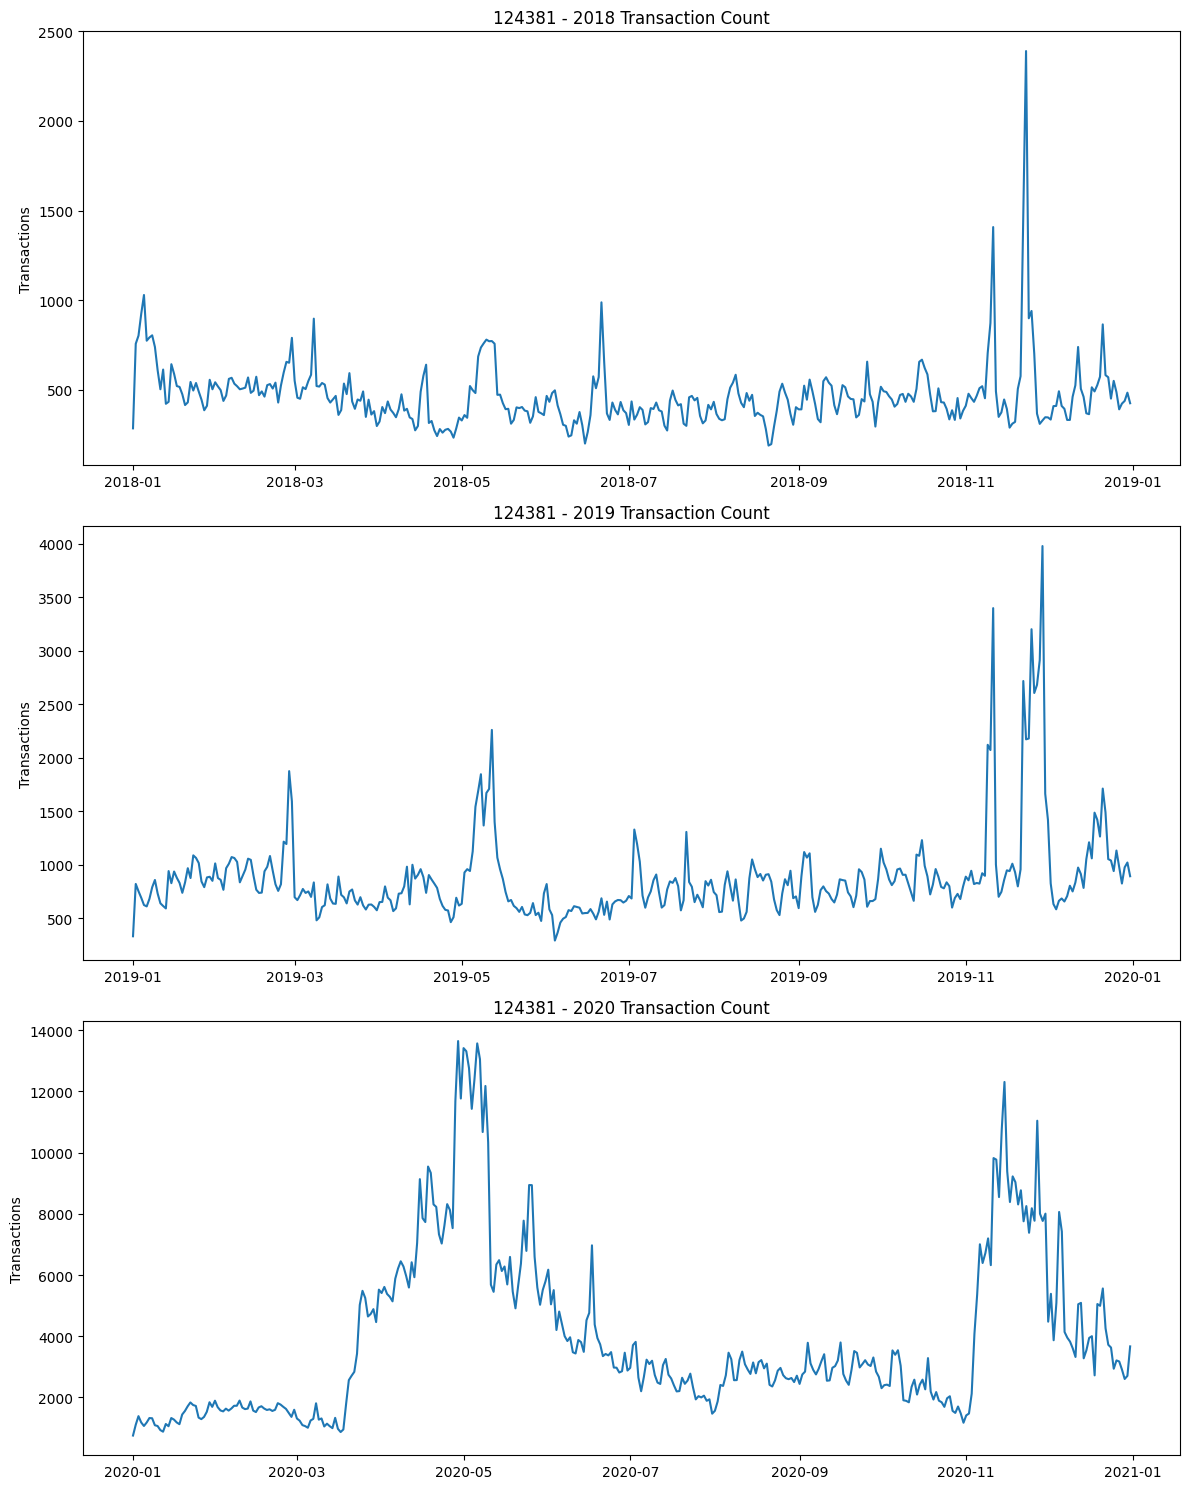

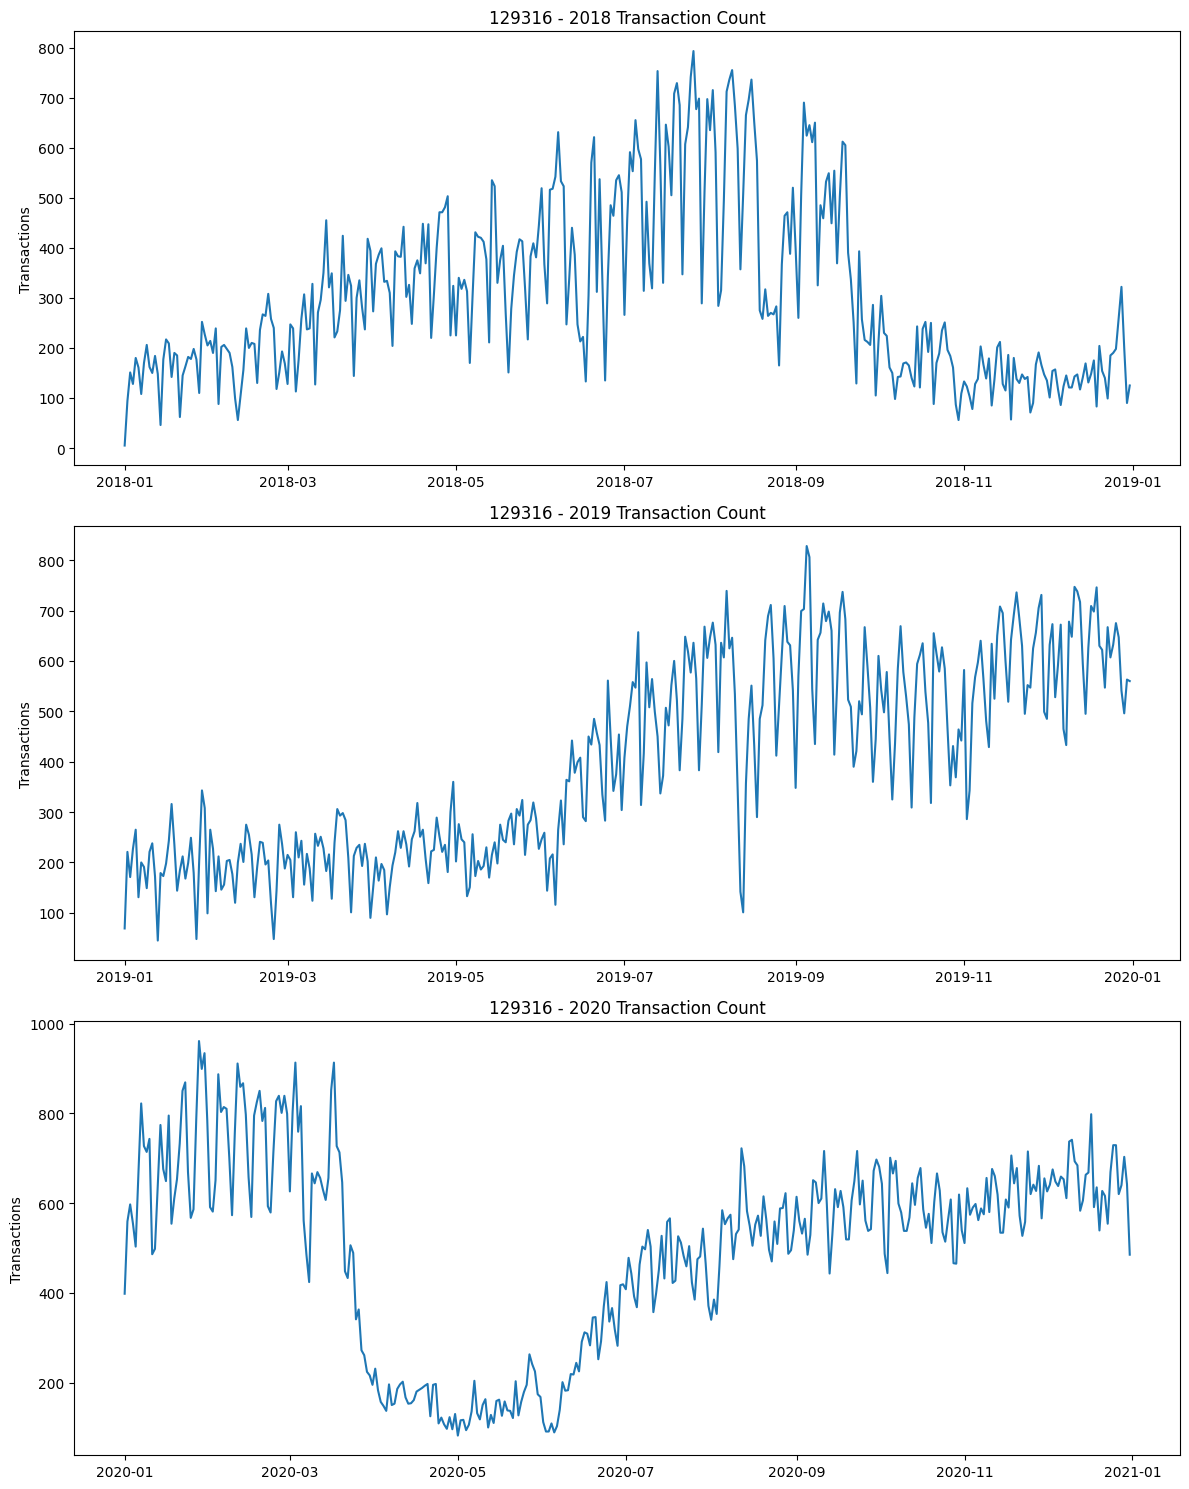

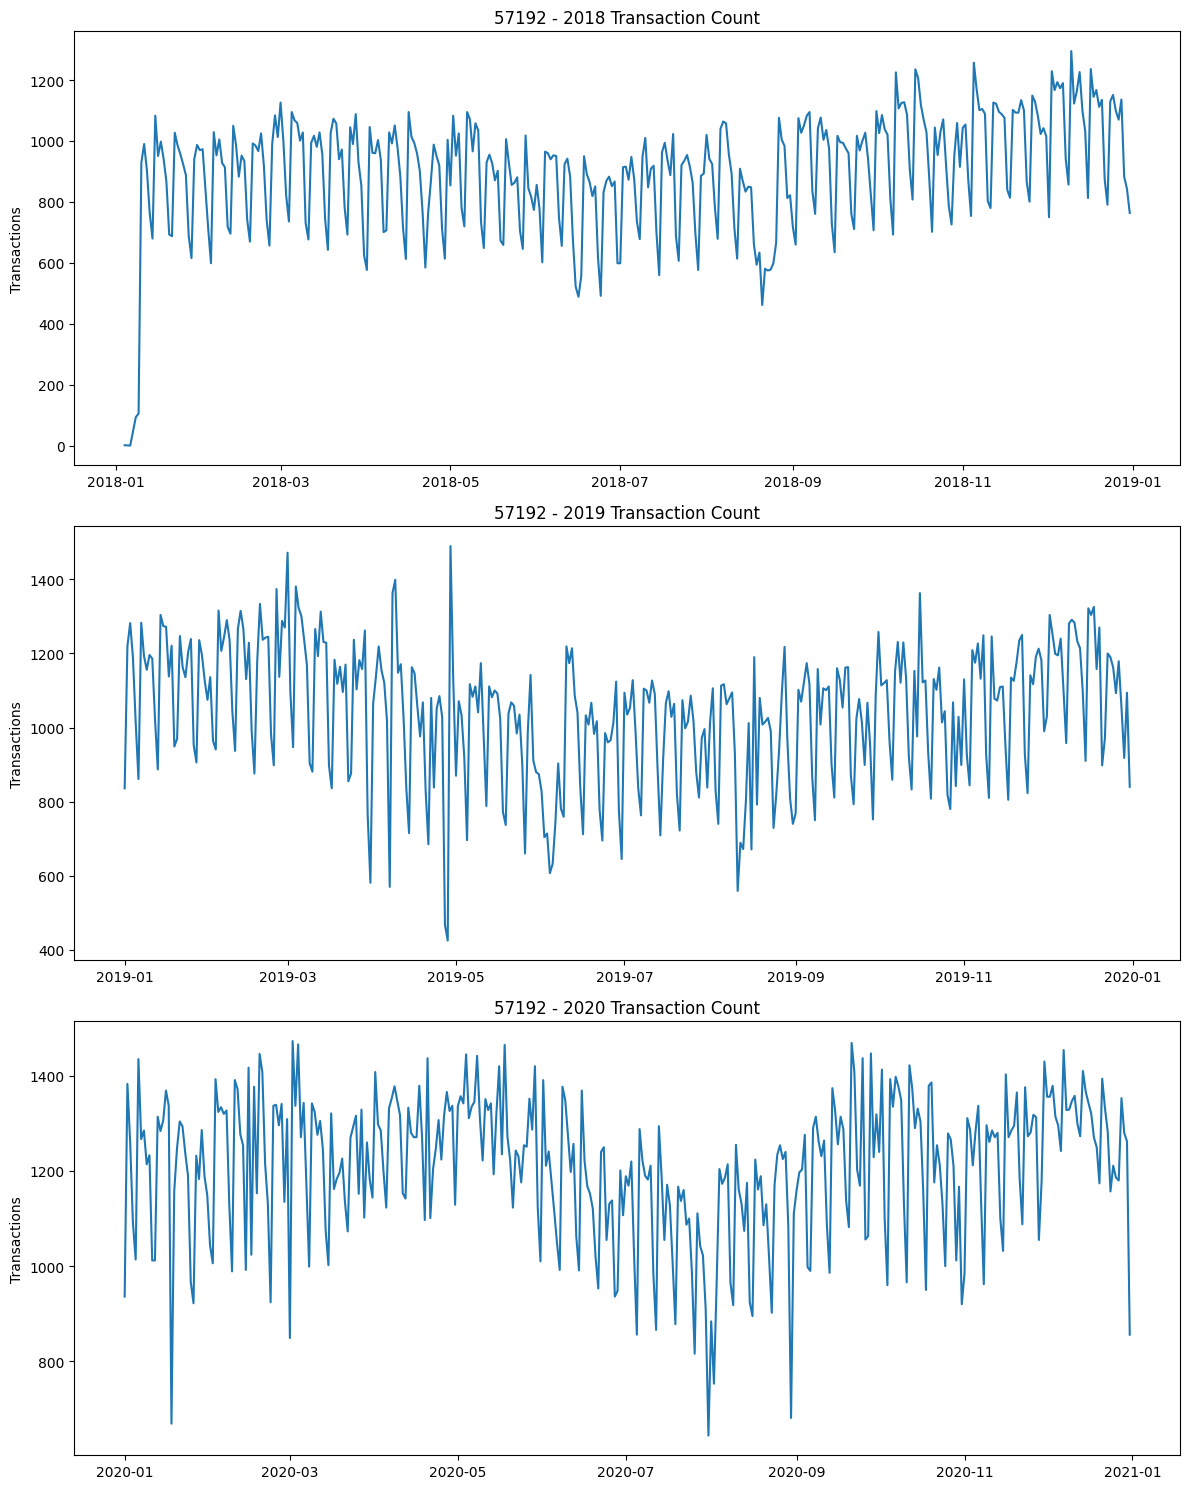

In [30]:
def plot_transaction_trends(df, years):
    for merchant in df["merchant_id"].unique():
        plt.figure(figsize=(12, 5 * len(years)))
        for i, year in enumerate(years):
            plt.subplot(len(years), 1, i+1)
            yearly_data = df[
                (df["merchant_id"] == merchant) &
                (df["transaction_date"] >= f"{year}-01-01") &
                (df["transaction_date"] < f"{year+1}-01-01")
            ]
            plt.plot(yearly_data["transaction_date"], yearly_data["Total_Transaction"])
            plt.title(f"{merchant} - {year} Transaction Count")
            plt.xlabel('')
            plt.ylabel('Transactions')
        plt.tight_layout()
        plt.show()

plot_transaction_trends(df, [2018,2019,2020])

## 3. Feature Engineering

### 3.1. Date Features

We will produce date features to obtain information about trends and capture seasonality.

In [31]:
def create_date_features(df, date_col="transaction_date"):
    df["month"] = df[date_col].dt.month
    df["day_of_month"] = df[date_col].dt.day
    df["day_of_year"] = df[date_col].dt.dayofyear
    df["week_of_year"] = df[date_col].dt.isocalendar().week.astype(int)
    df["day_of_week"] = df[date_col].dt.weekday
    df["year"] = df[date_col].dt.year
    df["is_wknd"] = (df[date_col].dt.weekday >= 5).astype(int)
    df["is_month_start"] = df[date_col].dt.is_month_start.astype(int)
    df["is_month_end"] = df[date_col].dt.is_month_end.astype(int)
    df['quarter'] = df[date_col].dt.quarter
    df['is_quarter_start'] = df[date_col].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_col].dt.is_quarter_end.astype(int)
    df["is_year_start"] = df[date_col].dt.is_year_start.astype(int)
    df["is_year_end"] = df[date_col].dt.is_year_end.astype(int)
    return df

df = create_date_features(df)

In [32]:
df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end
0       2018-01-01          535                349   25883.226      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0
1       2018-01-01        42616                141   40918.860      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0
2       2018-01-01        46774                410  306902.700      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0
3       2018-01-01        86302                 10      11.340      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0
4       2018-01-01       124381                285  111383.766      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0

Let's observe the monthly transaction volume of member businesses:

In [37]:
pivot_df = df.pivot_table(
    values = "Total_Transaction",
    index = "merchant_id",
    columns = "month",
    aggfunc="sum",
    fill_value=0
)

pivot_df

month            1       2       3       4       5       6       7       8       9       10      11      12
merchant_id                                                                                                
535           90575   90179   89794   75730   94574  100732  113978  119515  139558  141655  128612  117823
42616        138574   58989   67023   68722   96110  126971   92653   54623   65077   73681  195735   88033
46774        122461  121117  127798  126886  131295  125954  133344  129618  137034  139278  146399  158375
57192         91382   93544  101030   94996   97691   85495   89866   87549   94910  101172  100470  108335
86302         12108   12590   18936   51227   80821   85917   85357  101892  104164   96732   93160   98047
124381        84351   90311  110130  258403  299951  149339  116495  121567  126900  110597  292672  174641
129316        32148   32631   32756   22390   22973   30227   47565   48165   47878   39418   40031   43847

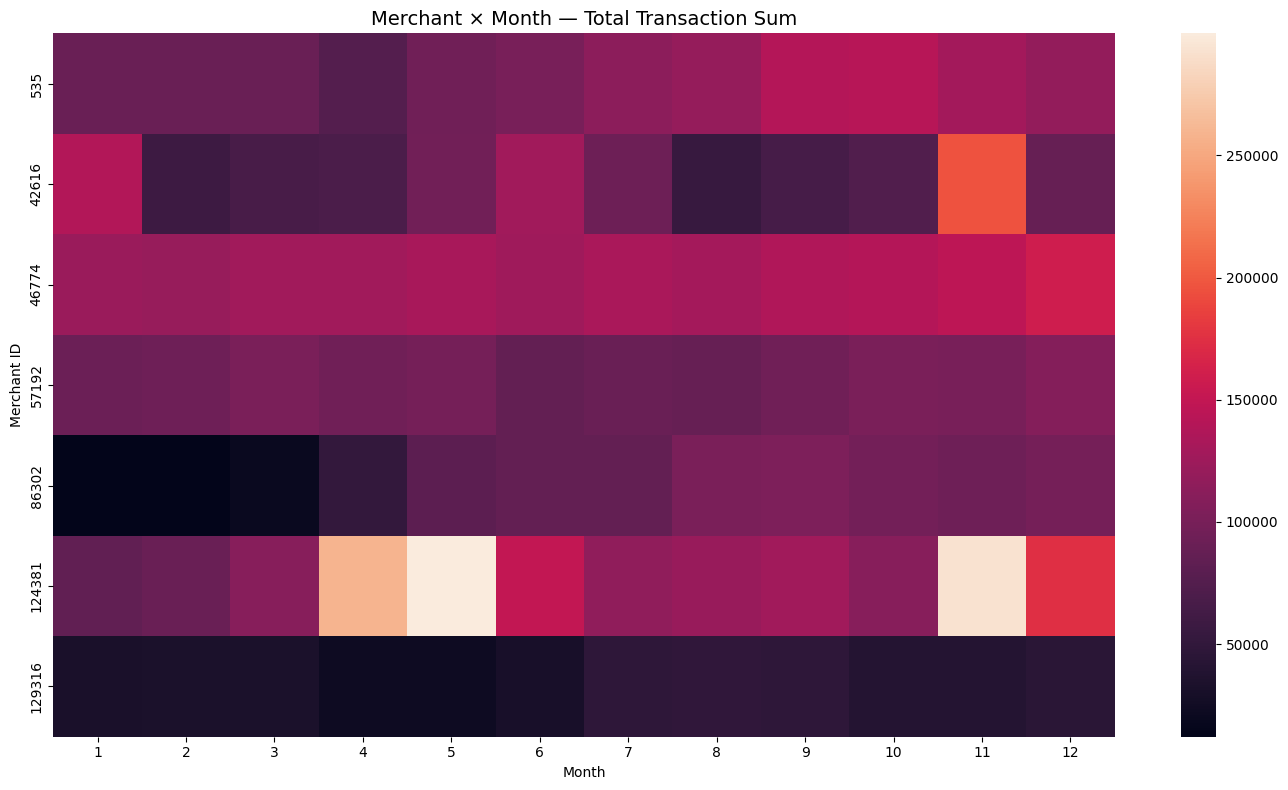

In [39]:
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, annot=False)
plt.title("Merchant × Month — Total Transaction Sum", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Merchant ID")
plt.tight_layout()
plt.show()

In [41]:
# summary of the transaction amount of the merchants by month and year

df.groupby(["merchant_id", "year", "month"]).agg({
    "Total_Transaction": ["sum", "mean", "median"]
}).head(20)

Total_Transaction                  
                                     sum     mean   median
merchant_id year month                                    
535         2018 1                 20927  675.065  695.000
                 2                 20247  723.107  750.500
                 3                 22807  735.710  725.000
                 4                 22459  748.633  760.500
                 5                 24443  788.484  804.000
                 6                 20376  679.200  748.000
                 7                 23032  742.968  767.000
                 8                 21949  708.032  748.000
                 9                 26982  899.400  932.500
                 10                25516  823.097  830.000
                 11                22573  752.433  795.500
                 12                22091  712.613  774.000
            2019 1                 22586  728.581  753.000
                 2                 22041  787.179  832.000
                 3                 25314  816.581  883.000
                 4                 25862  862.067  899.500
                 5                 31060 1001.935  984.000
                 6                 28917  963.900 1009.500
                 7                 38444 1240.129 1254.000
                 8                 40455 1305.000 1369.000

In [43]:
df.groupby(["merchant_id", "year", "month", "day_of_month"]).agg({"Total_Paid":["sum","mean","median"]}).head(20)

Total_Paid                    
                                           sum      mean    median
merchant_id year month day_of_month                               
535         2018 1     1             25883.226 25883.226 25883.226
                       2             60263.928 60263.928 60263.928
                       3             51071.994 51071.994 51071.994
                       4             56995.110 56995.110 56995.110
                       5             66689.352 66689.352 66689.352
                       6             55923.588 55923.588 55923.588
                       7             65682.396 65682.396 65682.396
                       8             65227.608 65227.608 65227.608
                       9             78227.118 78227.118 78227.118
                       10            76767.552 76767.552 76767.552
                       11            59445.396 59445.396 59445.396
                       12            88896.528 88896.528 88896.528
                       13            68158.134 68158.134 68158.134
                       14            53815.896 53815.896 53815.896
                       15            72639.756 72639.756 72639.756
                       16            71088.660 71088.660 71088.660
                       17            71940.006 71940.006 71940.006
                       18            71728.992 71728.992 71728.992
                       19            83748.060 83748.060 83748.060
                       20            61553.664 61553.664 61553.664

### 3.2 Lag/Shifted Features

Lag values will be generated using the Total_Transaction variable. When we generate these values, random noise is added to the dataset to prevent overfitting.

In [46]:
## Random Noise:

def random_noise(dataframe):
    return np.random.normal(scale = 1.6, size = (len(dataframe),))

In [48]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe["transaction_lag_" + str(lag)] = dataframe.groupby(["merchant_id"])["Total_Transaction"].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])

df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  transaction_lag_91  transaction_lag_92  transaction_lag_170  transaction_lag_171  transaction_lag_172  transaction_lag_173  transaction_lag_174  transaction_lag_175  transaction_lag_176  transaction_lag_177  transaction_lag_178  transaction_lag_179  \
0       2018-01-01          535                349   25883.226      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1       2018-01-01        42616                141   40918.860      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
2       2018-01-01        46774                410  306902.700      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
3       2018-01-01        86302                 10      11.340      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
4       2018-01-01       124381                285  111383.766      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   

   transaction_lag_180  transaction_lag_181  transaction_lag_182  transaction_lag_183  transaction_lag_184  transaction_lag_185  transaction_lag_186  transaction_lag_187  transaction_lag_188  transaction_lag_189  transaction_lag_190  transaction_lag_350  transaction_lag_351  transaction_lag_352  transaction_lag_354  transaction_lag_355  transaction_lag_356  transaction_lag_357  transaction_lag_358  transaction_lag_359  transaction_lag_360  transaction_lag_361  transaction_lag_362  \
0                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   

### 3.3. Rolling Mean Features

In [51]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe["transaction_roll_mean_" + str(window)] = dataframe.groupby(["merchant_id"])["Total_Transaction"]. \
                                                        transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

df = roll_mean_features(df,[91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])

In [53]:
df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  transaction_lag_91  transaction_lag_92  transaction_lag_170  transaction_lag_171  transaction_lag_172  transaction_lag_173  transaction_lag_174  transaction_lag_175  transaction_lag_176  transaction_lag_177  transaction_lag_178  transaction_lag_179  \
0       2018-01-01          535                349   25883.226      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1       2018-01-01        42616                141   40918.860      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
2       2018-01-01        46774                410  306902.700      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
3       2018-01-01        86302                 10      11.340      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
4       2018-01-01       124381                285  111383.766      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   

   transaction_lag_180  transaction_lag_181  transaction_lag_182  transaction_lag_183  transaction_lag_184  transaction_lag_185  transaction_lag_186  transaction_lag_187  transaction_lag_188  transaction_lag_189  transaction_lag_190  transaction_lag_350  transaction_lag_351  transaction_lag_352  transaction_lag_354  transaction_lag_355  transaction_lag_356  transaction_lag_357  transaction_lag_358  transaction_lag_359  transaction_lag_360  transaction_lag_361  transaction_lag_362  \
0                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   

### 3.4. Exponentially Weighted Mean Features

Exponentially weighted averages are added to the data set according to different alpha values.

In [56]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe["transaction_ewm_alpha_" + str(alpha).replace(".","") + str(lag)] = \
                dataframe.groupby(["merchant_id"])["Total_Transaction"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)

df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  transaction_lag_91  transaction_lag_92  transaction_lag_170  transaction_lag_171  transaction_lag_172  transaction_lag_173  transaction_lag_174  transaction_lag_175  transaction_lag_176  transaction_lag_177  transaction_lag_178  transaction_lag_179  \
0       2018-01-01          535                349   25883.226      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1       2018-01-01        42616                141   40918.860      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
2       2018-01-01        46774                410  306902.700      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
3       2018-01-01        86302                 10      11.340      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
4       2018-01-01       124381                285  111383.766      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   

   transaction_lag_180  transaction_lag_181  transaction_lag_182  transaction_lag_183  transaction_lag_184  transaction_lag_185  transaction_lag_186  transaction_lag_187  transaction_lag_188  transaction_lag_189  transaction_lag_190  transaction_lag_350  transaction_lag_351  transaction_lag_352  transaction_lag_354  transaction_lag_355  transaction_lag_356  transaction_lag_357  transaction_lag_358  transaction_lag_359  transaction_lag_360  transaction_lag_361  transaction_lag_362  \
0                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   

### 3.5. Special Days Features

In [59]:
# Black Friday

def is_black_friday(date):
    if date.month == 11:
        month_days = pd.date_range(start=date.replace(day=1), end=date.replace(day=30))
        fridays = [d for d in month_days if d.weekday() == 4]
        last_friday = fridays[-1]
        return int(date == last_friday)
    return 0

df["is_black_friday"] = df["transaction_date"].apply(is_black_friday)

In [61]:
def is_summer_solstice(date):
    return int(date.month == 6 and date.day in [19, 20, 21, 22])

df["is_summer_solstice"] = df["transaction_date"].apply(is_summer_solstice)

In [63]:
# Black Week

df["is_black_week"] = df["transaction_date"].apply(lambda x: int(x.month == 11 and x.week >= 47))

In [65]:
# Salary Payment Effect

df["is_salary_period"] = df["day_of_month"].between(1, 5).astype(int)

## 4. One-Hot-Encoding

In [68]:
df.head()

transaction_date  merchant_id  Total_Transaction  Total_Paid  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  transaction_lag_91  transaction_lag_92  transaction_lag_170  transaction_lag_171  transaction_lag_172  transaction_lag_173  transaction_lag_174  transaction_lag_175  transaction_lag_176  transaction_lag_177  transaction_lag_178  transaction_lag_179  \
0       2018-01-01          535                349   25883.226      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1       2018-01-01        42616                141   40918.860      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
2       2018-01-01        46774                410  306902.700      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
3       2018-01-01        86302                 10      11.340      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
4       2018-01-01       124381                285  111383.766      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0                 NaN                 NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   

   transaction_lag_180  transaction_lag_181  transaction_lag_182  transaction_lag_183  transaction_lag_184  transaction_lag_185  transaction_lag_186  transaction_lag_187  transaction_lag_188  transaction_lag_189  transaction_lag_190  transaction_lag_350  transaction_lag_351  transaction_lag_352  transaction_lag_354  transaction_lag_355  transaction_lag_356  transaction_lag_357  transaction_lag_358  transaction_lag_359  transaction_lag_360  transaction_lag_361  transaction_lag_362  \
0                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   

In [70]:
df = pd.get_dummies(df, columns=["merchant_id","day_of_week","month"], dtype=int)

## 5. Log of Dependent Variable

In [73]:
df["Total_Transaction"] = np.log1p(df["Total_Transaction"].values)

## 6. Custom Cost Function

SMAPE: Symetric mean absolute percentage error (adjusted MAPE)

In [76]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num/denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels=train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return "SMAPE", smape_val, False

## 7. Time-Based Validation Sets

The final three months of 2020 are to be forecasted. We will use the final three months of 2019 as the validation set.

In [78]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train = df.loc[(df["transaction_date"]< "2020-10-01"), :]
val = df.loc[(df["transaction_date"] >= "2020-10-01"), :]

cols = [col for col in train.columns if col not in ["transaction_date", "Total_Transaction", "Total_Paid", "year"]]

Y_train = train["Total_Transaction"]
X_train = train[cols]

Y_val = val["Total_Transaction"]
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 214), (644,), (644, 214))

In [80]:
lgbtrain = lgb.Dataset(data = X_train, label = Y_train, feature_name=cols)
lgbval = lgb.Dataset(data = X_val, label = Y_val, reference=lgbtrain, feature_name=cols)

## 8. Time Series Model with LGBM

We will forecast member merchant transaction volumes using the LGBM model for the last three months of 2020. Beforehand, we will conduct hyperparameter optimization with optuna.

### 8.1 Hyperparameter Optimization

In [85]:
import optuna
from sklearn.metrics import mean_absolute_error, make_scorer

In [87]:
def objective(trial):
    param_grid = {
        "metric": {'mae'},
        "verbosity":-1,
        "objective": "regression",
        "boosting_type": "gbdt",
        "nthread": -1,
        "num_leaves": trial.suggest_int("num_leaves",10,100),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 0.9),
        "max_depth": trial.suggest_int("max_depth", -1, 10)
    }

    model = lgb.train(
        param_grid,
        lgbtrain,
        valid_sets=[lgbtrain,lgbval],
        num_boost_round = 5000,
        feval = lgbm_smape,
        callbacks=[
            lgb.early_stopping(200),
            lgb.log_evaluation(period=100)
        ]
    )

    valid_name = list(model.best_score.keys())[-1]
    metric_name = list(model.best_score[valid_name].keys())[0]
    best_smape = model.best_score[valid_name][metric_name]

    # Print best SMAPE from LightGBM during this trial
    print(f"Trial {trial.number} - Best {metric_name}: {round(best_smape, 4)}")

    trial.set_user_attr("best_smape", best_smape)
    trial.set_user_attr("best_iteration", model.best_iteration)

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    score = mean_absolute_error(np.expm1(Y_val), np.expm1(y_pred))

    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best trial
best_trial = study.best_trial

print("Best trial params:", best_trial.params)
print("Best SMAPE across trials:", best_trial.user_attrs["best_smape"])
best_iteration = best_trial.user_attrs["best_iteration"]
print("Best iteration:", best_iteration)

[I 2025-12-11 12:49:23,317] A new study created in memory with name: no-name-84aeb624-3b21-442f-97e3-75d0b06f636c


Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.139236	training's SMAPE: 13.7003	valid_1's l1: 0.238246	valid_1's SMAPE: 23.1108
[200]	training's l1: 0.102906	training's SMAPE: 10.1714	valid_1's l1: 0.245865	valid_1's SMAPE: 23.889


[I 2025-12-11 12:49:25,792] Trial 0 finished with value: 591.8047349671473 and parameters: {'num_leaves': 22, 'learning_rate': 0.1345867798315895, 'feature_fraction': 0.3885042282858969, 'max_depth': 8}. Best is trial 0 with value: 591.8047349671473.


Early stopping, best iteration is:
[34]	training's l1: 0.189249	training's SMAPE: 18.4505	valid_1's l1: 0.228954	valid_1's SMAPE: 22.1327
Trial 0 - Best l1: 0.229
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.356234	training's SMAPE: 33.8582	valid_1's l1: 0.424797	valid_1's SMAPE: 40.0104
[200]	training's l1: 0.243806	training's SMAPE: 23.5438	valid_1's l1: 0.267806	valid_1's SMAPE: 25.5647
[300]	training's l1: 0.210068	training's SMAPE: 20.397	valid_1's l1: 0.235801	valid_1's SMAPE: 22.6561
[400]	training's l1: 0.193923	training's SMAPE: 18.8902	valid_1's l1: 0.225481	valid_1's SMAPE: 21.7586
[500]	training's l1: 0.183968	training's SMAPE: 17.9574	valid_1's l1: 0.221506	valid_1's SMAPE: 21.442
[600]	training's l1: 0.176313	training's SMAPE: 17.2338	valid_1's l1: 0.221013	valid_1's SMAPE: 21.4207
[700]	training's l1: 0.170068	training's SMAPE: 16.6415	valid_1's l1: 0.221503	valid_1's SMAPE: 21.4841
Early stopping, best iteration is:
[516]	training

[I 2025-12-11 12:49:34,348] Trial 1 finished with value: 585.1240015010467 and parameters: {'num_leaves': 19, 'learning_rate': 0.010988432402028205, 'feature_fraction': 0.8087981503377913, 'max_depth': 7}. Best is trial 1 with value: 585.1240015010467.


Trial 1 - Best l1: 0.2206
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.131297	training's SMAPE: 12.9387	valid_1's l1: 0.232842	valid_1's SMAPE: 22.6484
[200]	training's l1: 0.0968128	training's SMAPE: 9.58298	valid_1's l1: 0.248489	valid_1's SMAPE: 24.1921


[I 2025-12-11 12:49:36,611] Trial 2 finished with value: 593.0064987150143 and parameters: {'num_leaves': 82, 'learning_rate': 0.1917116703758977, 'feature_fraction': 0.7619736436326628, 'max_depth': 5}. Best is trial 1 with value: 585.1240015010467.


Early stopping, best iteration is:
[42]	training's l1: 0.168909	training's SMAPE: 16.5399	valid_1's l1: 0.213749	valid_1's SMAPE: 20.639
Trial 2 - Best l1: 0.2137
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.272784	training's SMAPE: 26.2682	valid_1's l1: 0.228127	valid_1's SMAPE: 22.0227
[200]	training's l1: 0.245844	training's SMAPE: 23.7806	valid_1's l1: 0.237876	valid_1's SMAPE: 23.1436


[I 2025-12-11 12:49:37,766] Trial 3 finished with value: 592.9165955224585 and parameters: {'num_leaves': 63, 'learning_rate': 0.07744050826869796, 'feature_fraction': 0.7611389019766993, 'max_depth': 2}. Best is trial 1 with value: 585.1240015010467.


[300]	training's l1: 0.228619	training's SMAPE: 22.1705	valid_1's l1: 0.248856	valid_1's SMAPE: 24.2608
Early stopping, best iteration is:
[132]	training's l1: 0.261356	training's SMAPE: 25.2189	valid_1's l1: 0.221838	valid_1's SMAPE: 21.5068
Trial 3 - Best l1: 0.2218
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.110672	training's SMAPE: 10.9045	valid_1's l1: 0.229903	valid_1's SMAPE: 22.3591
[200]	training's l1: 0.0792373	training's SMAPE: 7.84231	valid_1's l1: 0.243154	valid_1's SMAPE: 23.6603


[I 2025-12-11 12:49:40,974] Trial 4 finished with value: 591.2205422478162 and parameters: {'num_leaves': 66, 'learning_rate': 0.1489382959540113, 'feature_fraction': 0.38134036491479395, 'max_depth': 7}. Best is trial 1 with value: 585.1240015010467.


Early stopping, best iteration is:
[75]	training's l1: 0.120525	training's SMAPE: 11.8632	valid_1's l1: 0.225031	valid_1's SMAPE: 21.8836
Trial 4 - Best l1: 0.225
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.144887	training's SMAPE: 14.1573	valid_1's l1: 0.221366	valid_1's SMAPE: 21.2721
[200]	training's l1: 0.115095	training's SMAPE: 11.2971	valid_1's l1: 0.220655	valid_1's SMAPE: 21.3028


[I 2025-12-11 12:49:45,376] Trial 5 finished with value: 603.3688160583364 and parameters: {'num_leaves': 88, 'learning_rate': 0.04209164262908206, 'feature_fraction': 0.13014328181589851, 'max_depth': 9}. Best is trial 1 with value: 585.1240015010467.


[300]	training's l1: 0.0968802	training's SMAPE: 9.52561	valid_1's l1: 0.229762	valid_1's SMAPE: 22.2214
Early stopping, best iteration is:
[110]	training's l1: 0.139789	training's SMAPE: 13.6675	valid_1's l1: 0.219233	valid_1's SMAPE: 21.0812
Trial 5 - Best l1: 0.2192
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.246208	training's SMAPE: 23.814	valid_1's l1: 0.240466	valid_1's SMAPE: 23.3624
[200]	training's l1: 0.218401	training's SMAPE: 21.216	valid_1's l1: 0.246768	valid_1's SMAPE: 24.0682
Early stopping, best iteration is:
[74]	training's l1: 0.259274	training's SMAPE: 25.0431	valid_1's l1: 0.234751	valid_1's SMAPE: 22.7194


[I 2025-12-11 12:49:46,223] Trial 6 finished with value: 648.3903207301008 and parameters: {'num_leaves': 80, 'learning_rate': 0.17766065337234196, 'feature_fraction': 0.2693447200629245, 'max_depth': 2}. Best is trial 1 with value: 585.1240015010467.


Trial 6 - Best l1: 0.2348
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0742115	training's SMAPE: 7.35978	valid_1's l1: 0.257706	valid_1's SMAPE: 24.911
[200]	training's l1: 0.0419273	training's SMAPE: 4.17795	valid_1's l1: 0.260293	valid_1's SMAPE: 25.1432
[300]	training's l1: 0.0272464	training's SMAPE: 2.72243	valid_1's l1: 0.259557	valid_1's SMAPE: 25.0728


[I 2025-12-11 12:49:54,389] Trial 7 finished with value: 621.6801619036962 and parameters: {'num_leaves': 52, 'learning_rate': 0.17097817585727207, 'feature_fraction': 0.8070856885187722, 'max_depth': 0}. Best is trial 1 with value: 585.1240015010467.


Early stopping, best iteration is:
[118]	training's l1: 0.0653776	training's SMAPE: 6.48591	valid_1's l1: 0.255251	valid_1's SMAPE: 24.6769
Trial 7 - Best l1: 0.2553
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.266001	training's SMAPE: 25.6544	valid_1's l1: 0.239316	valid_1's SMAPE: 23.2532


[I 2025-12-11 12:49:55,319] Trial 8 finished with value: 631.1421628769655 and parameters: {'num_leaves': 11, 'learning_rate': 0.09673543237912939, 'feature_fraction': 0.8569897193013886, 'max_depth': 2}. Best is trial 1 with value: 585.1240015010467.


[200]	training's l1: 0.238107	training's SMAPE: 23.0679	valid_1's l1: 0.245017	valid_1's SMAPE: 23.871
Early stopping, best iteration is:
[48]	training's l1: 0.294863	training's SMAPE: 28.256	valid_1's l1: 0.23363	valid_1's SMAPE: 22.404
Trial 8 - Best l1: 0.2336
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.151463	training's SMAPE: 14.8556	valid_1's l1: 0.249059	valid_1's SMAPE: 24.1384
[200]	training's l1: 0.122229	training's SMAPE: 12.0409	valid_1's l1: 0.255538	valid_1's SMAPE: 24.8243


[I 2025-12-11 12:49:59,790] Trial 9 finished with value: 619.4325612577811 and parameters: {'num_leaves': 33, 'learning_rate': 0.05941356158903688, 'feature_fraction': 0.7284821945483523, 'max_depth': 8}. Best is trial 1 with value: 585.1240015010467.


Early stopping, best iteration is:
[87]	training's l1: 0.157781	training's SMAPE: 15.4546	valid_1's l1: 0.248181	valid_1's SMAPE: 24.0269
Trial 9 - Best l1: 0.2482
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.343015	training's SMAPE: 32.7471	valid_1's l1: 0.407186	valid_1's SMAPE: 38.3673
[200]	training's l1: 0.230937	training's SMAPE: 22.349	valid_1's l1: 0.256826	valid_1's SMAPE: 24.5278
[300]	training's l1: 0.200812	training's SMAPE: 19.508	valid_1's l1: 0.230606	valid_1's SMAPE: 22.1542
[400]	training's l1: 0.188506	training's SMAPE: 18.3525	valid_1's l1: 0.224805	valid_1's SMAPE: 21.6891
[500]	training's l1: 0.181089	training's SMAPE: 17.6565	valid_1's l1: 0.22003	valid_1's SMAPE: 21.2977
[600]	training's l1: 0.174342	training's SMAPE: 17.0174	valid_1's l1: 0.220345	valid_1's SMAPE: 21.3637
[700]	training's l1: 0.169469	training's SMAPE: 16.5577	valid_1's l1: 0.221227	valid_1's SMAPE: 21.4646


[I 2025-12-11 12:50:07,160] Trial 10 finished with value: 581.8971209813486 and parameters: {'num_leaves': 41, 'learning_rate': 0.011572820377357393, 'feature_fraction': 0.5947880345633789, 'max_depth': 5}. Best is trial 10 with value: 581.8971209813486.


Early stopping, best iteration is:
[547]	training's l1: 0.177938	training's SMAPE: 17.3589	valid_1's l1: 0.21946	valid_1's SMAPE: 21.2653
Trial 10 - Best l1: 0.2195
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.384431	training's SMAPE: 36.4531	valid_1's l1: 0.464751	valid_1's SMAPE: 43.5325
[200]	training's l1: 0.25402	training's SMAPE: 24.5275	valid_1's l1: 0.286401	valid_1's SMAPE: 27.2764
[300]	training's l1: 0.212683	training's SMAPE: 20.6269	valid_1's l1: 0.239395	valid_1's SMAPE: 22.9439
[400]	training's l1: 0.195793	training's SMAPE: 19.0355	valid_1's l1: 0.228973	valid_1's SMAPE: 22.0214
[500]	training's l1: 0.18728	training's SMAPE: 18.2378	valid_1's l1: 0.223781	valid_1's SMAPE: 21.6001
[600]	training's l1: 0.180914	training's SMAPE: 17.6383	valid_1's l1: 0.221091	valid_1's SMAPE: 21.3896
[700]	training's l1: 0.175932	training's SMAPE: 17.1709	valid_1's l1: 0.220943	valid_1's SMAPE: 21.404
[800]	training's l1: 0.171581	training's SMAPE: 

[I 2025-12-11 12:50:15,523] Trial 11 finished with value: 585.9745897910328 and parameters: {'num_leaves': 39, 'learning_rate': 0.009536289059429586, 'feature_fraction': 0.5763181534140952, 'max_depth': 5}. Best is trial 10 with value: 581.8971209813486.


Early stopping, best iteration is:
[660]	training's l1: 0.177683	training's SMAPE: 17.335	valid_1's l1: 0.220307	valid_1's SMAPE: 21.3292
Trial 11 - Best l1: 0.2203
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.300132	training's SMAPE: 28.8597	valid_1's l1: 0.373382	valid_1's SMAPE: 35.4409
[200]	training's l1: 0.196367	training's SMAPE: 19.086	valid_1's l1: 0.24613	valid_1's SMAPE: 23.6286
[300]	training's l1: 0.171683	training's SMAPE: 16.7543	valid_1's l1: 0.22839	valid_1's SMAPE: 22.0344
[400]	training's l1: 0.161224	training's SMAPE: 15.7656	valid_1's l1: 0.223236	valid_1's SMAPE: 21.6044
[500]	training's l1: 0.154114	training's SMAPE: 15.0915	valid_1's l1: 0.221478	valid_1's SMAPE: 21.4616
[600]	training's l1: 0.147857	training's SMAPE: 14.4946	valid_1's l1: 0.220923	valid_1's SMAPE: 21.4247
[700]	training's l1: 0.142946	training's SMAPE: 14.0259	valid_1's l1: 0.220674	valid_1's SMAPE: 21.4103
[800]	training's l1: 0.137976	training's SMAPE: 

[I 2025-12-11 12:50:27,167] Trial 12 finished with value: 582.7575709026203 and parameters: {'num_leaves': 41, 'learning_rate': 0.013224106996634958, 'feature_fraction': 0.6334489062231187, 'max_depth': 6}. Best is trial 10 with value: 581.8971209813486.


Early stopping, best iteration is:
[747]	training's l1: 0.140656	training's SMAPE: 13.8072	valid_1's l1: 0.220069	valid_1's SMAPE: 21.354
Trial 12 - Best l1: 0.2201
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.228016	training's SMAPE: 22.0626	valid_1's l1: 0.230991	valid_1's SMAPE: 22.1899
[200]	training's l1: 0.200152	training's SMAPE: 19.4792	valid_1's l1: 0.225666	valid_1's SMAPE: 21.9243
[300]	training's l1: 0.184475	training's SMAPE: 18.0044	valid_1's l1: 0.240023	valid_1's SMAPE: 23.3581


[I 2025-12-11 12:50:29,531] Trial 13 finished with value: 591.0446943440693 and parameters: {'num_leaves': 47, 'learning_rate': 0.03731088230187048, 'feature_fraction': 0.5625315316905755, 'max_depth': 4}. Best is trial 10 with value: 581.8971209813486.


Early stopping, best iteration is:
[157]	training's l1: 0.209302	training's SMAPE: 20.3305	valid_1's l1: 0.224721	valid_1's SMAPE: 21.7616
Trial 13 - Best l1: 0.2247
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.190285	training's SMAPE: 18.5161	valid_1's l1: 0.248114	valid_1's SMAPE: 23.8319
[200]	training's l1: 0.150343	training's SMAPE: 14.7414	valid_1's l1: 0.227138	valid_1's SMAPE: 21.9734
[300]	training's l1: 0.131698	training's SMAPE: 12.953	valid_1's l1: 0.227125	valid_1's SMAPE: 21.9976
[400]	training's l1: 0.117568	training's SMAPE: 11.582	valid_1's l1: 0.227304	valid_1's SMAPE: 22.0293


[I 2025-12-11 12:50:36,518] Trial 14 finished with value: 594.0346133538494 and parameters: {'num_leaves': 33, 'learning_rate': 0.030337882044946758, 'feature_fraction': 0.5290137291947862, 'max_depth': 10}. Best is trial 10 with value: 581.8971209813486.


Early stopping, best iteration is:
[248]	training's l1: 0.140188	training's SMAPE: 13.7699	valid_1's l1: 0.226316	valid_1's SMAPE: 21.9048
Trial 14 - Best l1: 0.2263
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.204744	training's SMAPE: 19.9128	valid_1's l1: 0.222482	valid_1's SMAPE: 21.588
[200]	training's l1: 0.177448	training's SMAPE: 17.3372	valid_1's l1: 0.232958	valid_1's SMAPE: 22.6841


[I 2025-12-11 12:50:38,400] Trial 15 finished with value: 582.5369990210185 and parameters: {'num_leaves': 66, 'learning_rate': 0.06450647127954565, 'feature_fraction': 0.6467527613572395, 'max_depth': 4}. Best is trial 10 with value: 581.8971209813486.


Early stopping, best iteration is:
[83]	training's l1: 0.212197	training's SMAPE: 20.6032	valid_1's l1: 0.222236	valid_1's SMAPE: 21.5172
Trial 15 - Best l1: 0.2222
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.237265	training's SMAPE: 22.9677	valid_1's l1: 0.234076	valid_1's SMAPE: 22.6767
[200]	training's l1: 0.208164	training's SMAPE: 20.2472	valid_1's l1: 0.256833	valid_1's SMAPE: 24.9853


[I 2025-12-11 12:50:39,741] Trial 16 finished with value: 600.8510351807927 and parameters: {'num_leaves': 99, 'learning_rate': 0.07019758525328848, 'feature_fraction': 0.6508500753776494, 'max_depth': 3}. Best is trial 10 with value: 581.8971209813486.


Early stopping, best iteration is:
[62]	training's l1: 0.258907	training's SMAPE: 24.947	valid_1's l1: 0.224313	valid_1's SMAPE: 21.5702
Trial 16 - Best l1: 0.2243
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0888578	training's SMAPE: 8.76352	valid_1's l1: 0.228906	valid_1's SMAPE: 22.1878
[200]	training's l1: 0.0559068	training's SMAPE: 5.53337	valid_1's l1: 0.238884	valid_1's SMAPE: 23.1906


[I 2025-12-11 12:50:47,719] Trial 17 finished with value: 593.8669705625096 and parameters: {'num_leaves': 65, 'learning_rate': 0.10254047477383665, 'feature_fraction': 0.4390553787532181, 'max_depth': 0}. Best is trial 10 with value: 581.8971209813486.


Early stopping, best iteration is:
[96]	training's l1: 0.0907936	training's SMAPE: 8.95412	valid_1's l1: 0.228444	valid_1's SMAPE: 22.1413
Trial 17 - Best l1: 0.2284
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.187304	training's SMAPE: 18.2777	valid_1's l1: 0.226092	valid_1's SMAPE: 21.9764
[200]	training's l1: 0.158121	training's SMAPE: 15.5114	valid_1's l1: 0.243395	valid_1's SMAPE: 23.7086


[I 2025-12-11 12:50:49,625] Trial 18 finished with value: 573.9696533342506 and parameters: {'num_leaves': 59, 'learning_rate': 0.1036691008036889, 'feature_fraction': 0.6698011899570901, 'max_depth': 4}. Best is trial 18 with value: 573.9696533342506.


Early stopping, best iteration is:
[80]	training's l1: 0.196223	training's SMAPE: 19.1216	valid_1's l1: 0.220027	valid_1's SMAPE: 21.3569
Trial 18 - Best l1: 0.22
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0888633	training's SMAPE: 8.76941	valid_1's l1: 0.234717	valid_1's SMAPE: 22.6776
[200]	training's l1: 0.0561106	training's SMAPE: 5.55566	valid_1's l1: 0.241046	valid_1's SMAPE: 23.282


[I 2025-12-11 12:50:56,082] Trial 19 finished with value: 604.2828305122555 and parameters: {'num_leaves': 56, 'learning_rate': 0.12016489377244087, 'feature_fraction': 0.4580698531577573, 'max_depth': -1}. Best is trial 18 with value: 573.9696533342506.


Early stopping, best iteration is:
[54]	training's l1: 0.120342	training's SMAPE: 11.8326	valid_1's l1: 0.228383	valid_1's SMAPE: 22.0254
Trial 19 - Best l1: 0.2284
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.144011	training's SMAPE: 14.1317	valid_1's l1: 0.225689	valid_1's SMAPE: 21.868
[200]	training's l1: 0.11724	training's SMAPE: 11.5595	valid_1's l1: 0.225763	valid_1's SMAPE: 21.9055


[I 2025-12-11 12:50:59,162] Trial 20 finished with value: 593.6798281267351 and parameters: {'num_leaves': 77, 'learning_rate': 0.09328091314416484, 'feature_fraction': 0.30592533573039216, 'max_depth': 6}. Best is trial 18 with value: 573.9696533342506.


[300]	training's l1: 0.0975161	training's SMAPE: 9.63188	valid_1's l1: 0.22634	valid_1's SMAPE: 21.9739
Early stopping, best iteration is:
[110]	training's l1: 0.141017	training's SMAPE: 13.848	valid_1's l1: 0.222565	valid_1's SMAPE: 21.5737
Trial 20 - Best l1: 0.2226
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.209551	training's SMAPE: 20.348	valid_1's l1: 0.230007	valid_1's SMAPE: 22.2502
[200]	training's l1: 0.182643	training's SMAPE: 17.8218	valid_1's l1: 0.232991	valid_1's SMAPE: 22.6565
[300]	training's l1: 0.165856	training's SMAPE: 16.2328	valid_1's l1: 0.240881	valid_1's SMAPE: 23.4453


[I 2025-12-11 12:51:01,488] Trial 21 finished with value: 596.8442889844248 and parameters: {'num_leaves': 58, 'learning_rate': 0.058099769015491735, 'feature_fraction': 0.6639196771948409, 'max_depth': 4}. Best is trial 18 with value: 573.9696533342506.


Early stopping, best iteration is:
[130]	training's l1: 0.199867	training's SMAPE: 19.4443	valid_1's l1: 0.22822	valid_1's SMAPE: 22.1582
Trial 21 - Best l1: 0.2282
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.183014	training's SMAPE: 17.867	valid_1's l1: 0.229961	valid_1's SMAPE: 22.3661
[200]	training's l1: 0.150864	training's SMAPE: 14.8134	valid_1's l1: 0.243005	valid_1's SMAPE: 23.6717


[I 2025-12-11 12:51:03,492] Trial 22 finished with value: 572.0182629716637 and parameters: {'num_leaves': 71, 'learning_rate': 0.11349982006372208, 'feature_fraction': 0.8969008528477229, 'max_depth': 4}. Best is trial 22 with value: 572.0182629716637.


Early stopping, best iteration is:
[60]	training's l1: 0.202605	training's SMAPE: 19.7097	valid_1's l1: 0.219752	valid_1's SMAPE: 21.3266
Trial 22 - Best l1: 0.2198
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.216263	training's SMAPE: 21.0211	valid_1's l1: 0.24324	valid_1's SMAPE: 23.706
[200]	training's l1: 0.184023	training's SMAPE: 17.9831	valid_1's l1: 0.25074	valid_1's SMAPE: 24.4881


[I 2025-12-11 12:51:04,884] Trial 23 finished with value: 616.5306808395251 and parameters: {'num_leaves': 72, 'learning_rate': 0.11840120749549687, 'feature_fraction': 0.8696668643275158, 'max_depth': 3}. Best is trial 22 with value: 572.0182629716637.


Early stopping, best iteration is:
[50]	training's l1: 0.244917	training's SMAPE: 23.6919	valid_1's l1: 0.23727	valid_1's SMAPE: 22.9862
Trial 23 - Best l1: 0.2373
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.122143	training's SMAPE: 12.0291	valid_1's l1: 0.246571	valid_1's SMAPE: 23.9063
[200]	training's l1: 0.0920997	training's SMAPE: 9.11514	valid_1's l1: 0.246516	valid_1's SMAPE: 23.9088


[I 2025-12-11 12:51:07,993] Trial 24 finished with value: 596.2658878483426 and parameters: {'num_leaves': 46, 'learning_rate': 0.14856058338156186, 'feature_fraction': 0.6968933338752769, 'max_depth': 6}. Best is trial 22 with value: 572.0182629716637.


Early stopping, best iteration is:
[55]	training's l1: 0.147939	training's SMAPE: 14.5057	valid_1's l1: 0.241903	valid_1's SMAPE: 23.4609
Trial 24 - Best l1: 0.2419
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.229482	training's SMAPE: 22.2413	valid_1's l1: 0.233599	valid_1's SMAPE: 22.6588
[200]	training's l1: 0.199747	training's SMAPE: 19.4438	valid_1's l1: 0.245386	valid_1's SMAPE: 23.9015


[I 2025-12-11 12:51:09,184] Trial 25 finished with value: 599.6262237821746 and parameters: {'num_leaves': 91, 'learning_rate': 0.08384904778477337, 'feature_fraction': 0.5783351514320836, 'max_depth': 3}. Best is trial 22 with value: 572.0182629716637.


Early stopping, best iteration is:
[55]	training's l1: 0.258682	training's SMAPE: 24.9397	valid_1's l1: 0.220513	valid_1's SMAPE: 21.2469
Trial 25 - Best l1: 0.2205
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.153202	training's SMAPE: 15.0311	valid_1's l1: 0.233103	valid_1's SMAPE: 22.6887
[200]	training's l1: 0.121277	training's SMAPE: 11.9493	valid_1's l1: 0.236254	valid_1's SMAPE: 23.03


[I 2025-12-11 12:51:12,024] Trial 26 finished with value: 595.3934580516869 and parameters: {'num_leaves': 72, 'learning_rate': 0.11618801637216666, 'feature_fraction': 0.8777581855215384, 'max_depth': 5}. Best is trial 22 with value: 572.0182629716637.


Early stopping, best iteration is:
[58]	training's l1: 0.175069	training's SMAPE: 17.1007	valid_1's l1: 0.227119	valid_1's SMAPE: 22.0473
Trial 26 - Best l1: 0.2271
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.306906	training's SMAPE: 29.3307	valid_1's l1: 0.247959	valid_1's SMAPE: 23.9013
[200]	training's l1: 0.292862	training's SMAPE: 28.0935	valid_1's l1: 0.253261	valid_1's SMAPE: 24.4573
Early stopping, best iteration is:
[60]	training's l1: 0.317994	training's SMAPE: 30.2583	valid_1's l1: 0.241704	valid_1's SMAPE: 23.1177
Trial 27 - Best l1: 0.2417


[I 2025-12-11 12:51:12,821] Trial 27 finished with value: 648.9500320548879 and parameters: {'num_leaves': 53, 'learning_rate': 0.14017421586329787, 'feature_fraction': 0.49729829662669756, 'max_depth': 1}. Best is trial 22 with value: 572.0182629716637.


Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.217711	training's SMAPE: 21.1561	valid_1's l1: 0.24816	valid_1's SMAPE: 24.1442
[200]	training's l1: 0.187229	training's SMAPE: 18.2854	valid_1's l1: 0.255615	valid_1's SMAPE: 24.9102


[I 2025-12-11 12:51:14,230] Trial 28 finished with value: 583.2259619909181 and parameters: {'num_leaves': 28, 'learning_rate': 0.11306224843484527, 'feature_fraction': 0.7973765601285033, 'max_depth': 3}. Best is trial 22 with value: 572.0182629716637.


Early stopping, best iteration is:
[44]	training's l1: 0.251866	training's SMAPE: 24.3288	valid_1's l1: 0.221664	valid_1's SMAPE: 21.3807
Trial 28 - Best l1: 0.2217
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.120327	training's SMAPE: 11.8454	valid_1's l1: 0.23408	valid_1's SMAPE: 22.6284
[200]	training's l1: 0.0886415	training's SMAPE: 8.74377	valid_1's l1: 0.24774	valid_1's SMAPE: 23.9808


[I 2025-12-11 12:51:17,411] Trial 29 finished with value: 597.4777256350848 and parameters: {'num_leaves': 47, 'learning_rate': 0.12709810535765537, 'feature_fraction': 0.3624137221085085, 'max_depth': 7}. Best is trial 22 with value: 572.0182629716637.


Early stopping, best iteration is:
[80]	training's l1: 0.129755	training's SMAPE: 12.7574	valid_1's l1: 0.230216	valid_1's SMAPE: 22.2272
Trial 29 - Best l1: 0.2302
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.14803	training's SMAPE: 14.5344	valid_1's l1: 0.235378	valid_1's SMAPE: 22.9124
[200]	training's l1: 0.116456	training's SMAPE: 11.4937	valid_1's l1: 0.243665	valid_1's SMAPE: 23.733


[I 2025-12-11 12:51:19,543] Trial 30 finished with value: 589.8036133302935 and parameters: {'num_leaves': 58, 'learning_rate': 0.1359212097237552, 'feature_fraction': 0.6073758392306462, 'max_depth': 5}. Best is trial 22 with value: 572.0182629716637.


Early stopping, best iteration is:
[44]	training's l1: 0.178864	training's SMAPE: 17.4481	valid_1's l1: 0.228681	valid_1's SMAPE: 22.1872
Trial 30 - Best l1: 0.2287
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.249565	training's SMAPE: 24.0764	valid_1's l1: 0.247163	valid_1's SMAPE: 23.7078
[200]	training's l1: 0.213843	training's SMAPE: 20.7538	valid_1's l1: 0.22292	valid_1's SMAPE: 21.565
[300]	training's l1: 0.197272	training's SMAPE: 19.2003	valid_1's l1: 0.220874	valid_1's SMAPE: 21.4775
[400]	training's l1: 0.186751	training's SMAPE: 18.2089	valid_1's l1: 0.226114	valid_1's SMAPE: 22.0084


[I 2025-12-11 12:51:22,789] Trial 31 finished with value: 572.0199672958679 and parameters: {'num_leaves': 70, 'learning_rate': 0.0262778274419586, 'feature_fraction': 0.6734697879535299, 'max_depth': 4}. Best is trial 22 with value: 572.0182629716637.


Early stopping, best iteration is:
[251]	training's l1: 0.204803	training's SMAPE: 19.9086	valid_1's l1: 0.21981	valid_1's SMAPE: 21.3332
Trial 31 - Best l1: 0.2198
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.256904	training's SMAPE: 24.7622	valid_1's l1: 0.249291	valid_1's SMAPE: 23.8765
[200]	training's l1: 0.21826	training's SMAPE: 21.169	valid_1's l1: 0.218337	valid_1's SMAPE: 21.0633
[300]	training's l1: 0.202107	training's SMAPE: 19.6578	valid_1's l1: 0.214812	valid_1's SMAPE: 20.837
[400]	training's l1: 0.191429	training's SMAPE: 18.6611	valid_1's l1: 0.219135	valid_1's SMAPE: 21.2908


[I 2025-12-11 12:51:25,793] Trial 32 finished with value: 571.1276297629317 and parameters: {'num_leaves': 73, 'learning_rate': 0.024216038680394618, 'feature_fraction': 0.7150470881008266, 'max_depth': 4}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[254]	training's l1: 0.209035	training's SMAPE: 20.3098	valid_1's l1: 0.213745	valid_1's SMAPE: 20.6963
Trial 32 - Best l1: 0.2137
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.253084	training's SMAPE: 24.4138	valid_1's l1: 0.253015	valid_1's SMAPE: 24.2228
[200]	training's l1: 0.215998	training's SMAPE: 20.9562	valid_1's l1: 0.226211	valid_1's SMAPE: 21.8274
[300]	training's l1: 0.199584	training's SMAPE: 19.4217	valid_1's l1: 0.226969	valid_1's SMAPE: 22.0267


[I 2025-12-11 12:51:28,735] Trial 33 finished with value: 590.9526689725608 and parameters: {'num_leaves': 74, 'learning_rate': 0.02543768100213009, 'feature_fraction': 0.7131016592272547, 'max_depth': 4}. Best is trial 32 with value: 571.1276297629317.


[400]	training's l1: 0.18906	training's SMAPE: 18.4322	valid_1's l1: 0.23281	valid_1's SMAPE: 22.6317
Early stopping, best iteration is:
[210]	training's l1: 0.214097	training's SMAPE: 20.7803	valid_1's l1: 0.22471	valid_1's SMAPE: 21.704
Trial 33 - Best l1: 0.2247
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.2991	training's SMAPE: 28.622	valid_1's l1: 0.235658	valid_1's SMAPE: 22.5437
[200]	training's l1: 0.270483	training's SMAPE: 26.0542	valid_1's l1: 0.2263	valid_1's SMAPE: 21.8824
[300]	training's l1: 0.25574	training's SMAPE: 24.6979	valid_1's l1: 0.231101	valid_1's SMAPE: 22.4568


[I 2025-12-11 12:51:30,309] Trial 34 finished with value: 606.786221706878 and parameters: {'num_leaves': 82, 'learning_rate': 0.04130911574132272, 'feature_fraction': 0.8980015465838643, 'max_depth': 2}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[169]	training's l1: 0.277361	training's SMAPE: 26.6821	valid_1's l1: 0.224691	valid_1's SMAPE: 21.661
Trial 34 - Best l1: 0.2247
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.251015	training's SMAPE: 24.2354	valid_1's l1: 0.234012	valid_1's SMAPE: 22.6096
[200]	training's l1: 0.219999	training's SMAPE: 21.3663	valid_1's l1: 0.251484	valid_1's SMAPE: 24.4521


[I 2025-12-11 12:51:31,817] Trial 35 finished with value: 603.987406720273 and parameters: {'num_leaves': 87, 'learning_rate': 0.052744262526538924, 'feature_fraction': 0.757985990879059, 'max_depth': 3}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[79]	training's l1: 0.260899	training's SMAPE: 25.139	valid_1's l1: 0.229038	valid_1's SMAPE: 22.0628
Trial 35 - Best l1: 0.229
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.143863	training's SMAPE: 14.1194	valid_1's l1: 0.223992	valid_1's SMAPE: 21.6902
[200]	training's l1: 0.11582	training's SMAPE: 11.4098	valid_1's l1: 0.225596	valid_1's SMAPE: 21.8875


[I 2025-12-11 12:51:35,392] Trial 36 finished with value: 590.7947904083975 and parameters: {'num_leaves': 70, 'learning_rate': 0.08386844625375198, 'feature_fraction': 0.7973031364137428, 'max_depth': 6}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[79]	training's l1: 0.152015	training's SMAPE: 14.8974	valid_1's l1: 0.221079	valid_1's SMAPE: 21.3958
Trial 36 - Best l1: 0.2211
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.185697	training's SMAPE: 18.1169	valid_1's l1: 0.233378	valid_1's SMAPE: 22.7582
[200]	training's l1: 0.156624	training's SMAPE: 15.3605	valid_1's l1: 0.256258	valid_1's SMAPE: 25.018


[I 2025-12-11 12:51:37,263] Trial 37 finished with value: 590.5825779332481 and parameters: {'num_leaves': 63, 'learning_rate': 0.10407684008095895, 'feature_fraction': 0.6881567367571131, 'max_depth': 4}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[75]	training's l1: 0.194755	training's SMAPE: 18.9655	valid_1's l1: 0.230644	valid_1's SMAPE: 22.4403
Trial 37 - Best l1: 0.2306
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.394265	training's SMAPE: 36.6822	valid_1's l1: 0.467593	valid_1's SMAPE: 43.0134
[200]	training's l1: 0.340436	training's SMAPE: 32.1408	valid_1's l1: 0.316117	valid_1's SMAPE: 29.8199
[300]	training's l1: 0.320917	training's SMAPE: 30.4799	valid_1's l1: 0.260322	valid_1's SMAPE: 24.747
[400]	training's l1: 0.311958	training's SMAPE: 29.7311	valid_1's l1: 0.243874	valid_1's SMAPE: 23.3305
[500]	training's l1: 0.307083	training's SMAPE: 29.331	valid_1's l1: 0.242719	valid_1's SMAPE: 23.326
[600]	training's l1: 0.303203	training's SMAPE: 28.996	valid_1's l1: 0.245454	valid_1's SMAPE: 23.6448


[I 2025-12-11 12:51:39,353] Trial 38 finished with value: 651.7109024159176 and parameters: {'num_leaves': 80, 'learning_rate': 0.02338941832523989, 'feature_fraction': 0.8384113825699768, 'max_depth': 1}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[470]	training's l1: 0.30826	training's SMAPE: 29.4262	valid_1's l1: 0.242133	valid_1's SMAPE: 23.2424
Trial 38 - Best l1: 0.2421
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.100188	training's SMAPE: 9.89626	valid_1's l1: 0.24615	valid_1's SMAPE: 23.8302
[200]	training's l1: 0.0704233	training's SMAPE: 6.98724	valid_1's l1: 0.247912	valid_1's SMAPE: 24.0281


[I 2025-12-11 12:51:43,828] Trial 39 finished with value: 606.1624247875454 and parameters: {'num_leaves': 69, 'learning_rate': 0.16378150844863626, 'feature_fraction': 0.7521798981368817, 'max_depth': 7}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[86]	training's l1: 0.107876	training's SMAPE: 10.6431	valid_1's l1: 0.243248	valid_1's SMAPE: 23.5584
Trial 39 - Best l1: 0.2432
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.339307	training's SMAPE: 32.0539	valid_1's l1: 0.310543	valid_1's SMAPE: 29.2933
[200]	training's l1: 0.314361	training's SMAPE: 29.9733	valid_1's l1: 0.246821	valid_1's SMAPE: 23.6839
[300]	training's l1: 0.306641	training's SMAPE: 29.3312	valid_1's l1: 0.250857	valid_1's SMAPE: 24.1861
Early stopping, best iteration is:
[178]	training's l1: 0.316999	training's SMAPE: 30.1869	valid_1's l1: 0.243814	valid_1's SMAPE: 23.3482
Trial 40 - Best l1: 0.2438


[I 2025-12-11 12:51:44,788] Trial 40 finished with value: 653.7857717146974 and parameters: {'num_leaves': 61, 'learning_rate': 0.05203424513967788, 'feature_fraction': 0.12919863658767444, 'max_depth': 1}. Best is trial 32 with value: 571.1276297629317.


Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.429417	training's SMAPE: 40.3838	valid_1's l1: 0.515338	valid_1's SMAPE: 48.0217
[200]	training's l1: 0.285653	training's SMAPE: 27.4865	valid_1's l1: 0.333531	valid_1's SMAPE: 31.6734
[300]	training's l1: 0.229581	training's SMAPE: 22.2201	valid_1's l1: 0.26037	valid_1's SMAPE: 24.8692
[400]	training's l1: 0.205619	training's SMAPE: 19.9537	valid_1's l1: 0.237828	valid_1's SMAPE: 22.8227
[500]	training's l1: 0.194188	training's SMAPE: 18.8808	valid_1's l1: 0.23097	valid_1's SMAPE: 22.2258
[600]	training's l1: 0.187334	training's SMAPE: 18.2406	valid_1's l1: 0.226563	valid_1's SMAPE: 21.8577
[700]	training's l1: 0.182323	training's SMAPE: 17.7705	valid_1's l1: 0.222138	valid_1's SMAPE: 21.4863
[800]	training's l1: 0.177862	training's SMAPE: 17.3512	valid_1's l1: 0.220571	valid_1's SMAPE: 21.3644
[900]	training's l1: 0.174049	training's SMAPE: 16.992	valid_1's l1: 0.220425	valid_1's SMAPE: 21.3662
[1000

[I 2025-12-11 12:51:55,708] Trial 41 finished with value: 584.449109503142 and parameters: {'num_leaves': 75, 'learning_rate': 0.007750490768351388, 'feature_fraction': 0.6050785370130252, 'max_depth': 5}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[875]	training's l1: 0.174932	training's SMAPE: 17.075	valid_1's l1: 0.220181	valid_1's SMAPE: 21.3401
Trial 41 - Best l1: 0.2202
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.277896	training's SMAPE: 26.7638	valid_1's l1: 0.318637	valid_1's SMAPE: 30.2766
[200]	training's l1: 0.204091	training's SMAPE: 19.8085	valid_1's l1: 0.234083	valid_1's SMAPE: 22.4705
[300]	training's l1: 0.186978	training's SMAPE: 18.2105	valid_1's l1: 0.223424	valid_1's SMAPE: 21.554
[400]	training's l1: 0.177004	training's SMAPE: 17.274	valid_1's l1: 0.220149	valid_1's SMAPE: 21.3236
[500]	training's l1: 0.16931	training's SMAPE: 16.5458	valid_1's l1: 0.221095	valid_1's SMAPE: 21.446


[I 2025-12-11 12:52:00,800] Trial 42 finished with value: 579.5799941998138 and parameters: {'num_leaves': 51, 'learning_rate': 0.016484939495508163, 'feature_fraction': 0.49832542757774007, 'max_depth': 5}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[376]	training's l1: 0.179108	training's SMAPE: 17.4724	valid_1's l1: 0.219784	valid_1's SMAPE: 21.2756
Trial 42 - Best l1: 0.2198
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.163035	training's SMAPE: 15.9953	valid_1's l1: 0.243602	valid_1's SMAPE: 23.7487


[I 2025-12-11 12:52:02,304] Trial 43 finished with value: 602.5775174499468 and parameters: {'num_leaves': 50, 'learning_rate': 0.19771383564862205, 'feature_fraction': 0.5269693821387569, 'max_depth': 4}. Best is trial 32 with value: 571.1276297629317.


[200]	training's l1: 0.13047	training's SMAPE: 12.8701	valid_1's l1: 0.248401	valid_1's SMAPE: 24.2464
Early stopping, best iteration is:
[26]	training's l1: 0.214665	training's SMAPE: 20.8625	valid_1's l1: 0.226524	valid_1's SMAPE: 21.9046
Trial 43 - Best l1: 0.2265
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.235589	training's SMAPE: 22.7862	valid_1's l1: 0.273992	valid_1's SMAPE: 26.168
[200]	training's l1: 0.189343	training's SMAPE: 18.4251	valid_1's l1: 0.229881	valid_1's SMAPE: 22.1579
[300]	training's l1: 0.176163	training's SMAPE: 17.1896	valid_1's l1: 0.222061	valid_1's SMAPE: 21.517
[400]	training's l1: 0.166183	training's SMAPE: 16.2474	valid_1's l1: 0.222151	valid_1's SMAPE: 21.5578
[500]	training's l1: 0.158576	training's SMAPE: 15.5255	valid_1's l1: 0.221781	valid_1's SMAPE: 21.536
[600]	training's l1: 0.150417	training's SMAPE: 14.7459	valid_1's l1: 0.222772	valid_1's SMAPE: 21.6504


[I 2025-12-11 12:52:07,719] Trial 44 finished with value: 585.037017827777 and parameters: {'num_leaves': 61, 'learning_rate': 0.022552714729011675, 'feature_fraction': 0.4293021179494484, 'max_depth': 5}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[449]	training's l1: 0.162405	training's SMAPE: 15.8876	valid_1's l1: 0.220656	valid_1's SMAPE: 21.4192
Trial 44 - Best l1: 0.2207
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.274095	training's SMAPE: 26.378	valid_1's l1: 0.22709	valid_1's SMAPE: 21.9069
[200]	training's l1: 0.248941	training's SMAPE: 24.0632	valid_1's l1: 0.239304	valid_1's SMAPE: 23.261


[I 2025-12-11 12:52:09,062] Trial 45 finished with value: 599.8458053461343 and parameters: {'num_leaves': 67, 'learning_rate': 0.07349922980940343, 'feature_fraction': 0.8335960413022678, 'max_depth': 2}. Best is trial 32 with value: 571.1276297629317.


[300]	training's l1: 0.231941	training's SMAPE: 22.4775	valid_1's l1: 0.242752	valid_1's SMAPE: 23.6495
Early stopping, best iteration is:
[125]	training's l1: 0.266216	training's SMAPE: 25.6565	valid_1's l1: 0.223918	valid_1's SMAPE: 21.6669
Trial 45 - Best l1: 0.2239
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.190441	training's SMAPE: 18.5263	valid_1's l1: 0.225832	valid_1's SMAPE: 21.7159
[200]	training's l1: 0.156468	training's SMAPE: 15.3079	valid_1's l1: 0.21408	valid_1's SMAPE: 20.7042
[300]	training's l1: 0.141929	training's SMAPE: 13.9203	valid_1's l1: 0.211971	valid_1's SMAPE: 20.5342
[400]	training's l1: 0.131519	training's SMAPE: 12.9203	valid_1's l1: 0.215147	valid_1's SMAPE: 20.8627


[I 2025-12-11 12:52:13,745] Trial 46 finished with value: 577.5396294627704 and parameters: {'num_leaves': 83, 'learning_rate': 0.032704723513857295, 'feature_fraction': 0.20572976543219867, 'max_depth': 6}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[283]	training's l1: 0.144243	training's SMAPE: 14.1425	valid_1's l1: 0.211526	valid_1's SMAPE: 20.4929
Trial 46 - Best l1: 0.2115
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.152996	training's SMAPE: 14.9318	valid_1's l1: 0.225223	valid_1's SMAPE: 21.6685
[200]	training's l1: 0.122553	training's SMAPE: 12.0215	valid_1's l1: 0.21331	valid_1's SMAPE: 20.5943
[300]	training's l1: 0.108248	training's SMAPE: 10.6407	valid_1's l1: 0.210382	valid_1's SMAPE: 20.3322
[400]	training's l1: 0.0974393	training's SMAPE: 9.59152	valid_1's l1: 0.213182	valid_1's SMAPE: 20.622


[I 2025-12-11 12:52:21,758] Trial 47 finished with value: 580.4043808862533 and parameters: {'num_leaves': 85, 'learning_rate': 0.03497131026372692, 'feature_fraction': 0.20387591533096322, 'max_depth': 8}. Best is trial 32 with value: 571.1276297629317.


[500]	training's l1: 0.0892041	training's SMAPE: 8.78663	valid_1's l1: 0.214062	valid_1's SMAPE: 20.7199
Early stopping, best iteration is:
[306]	training's l1: 0.107842	training's SMAPE: 10.6013	valid_1's l1: 0.210349	valid_1's SMAPE: 20.3295
Trial 47 - Best l1: 0.2103
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.171754	training's SMAPE: 16.7523	valid_1's l1: 0.22078	valid_1's SMAPE: 21.2961
[200]	training's l1: 0.145141	training's SMAPE: 14.2268	valid_1's l1: 0.213526	valid_1's SMAPE: 20.6701
[300]	training's l1: 0.12991	training's SMAPE: 12.7667	valid_1's l1: 0.212302	valid_1's SMAPE: 20.5719
[400]	training's l1: 0.118377	training's SMAPE: 11.6545	valid_1's l1: 0.211572	valid_1's SMAPE: 20.5232
[500]	training's l1: 0.108256	training's SMAPE: 10.6691	valid_1's l1: 0.212017	valid_1's SMAPE: 20.5723


[I 2025-12-11 12:52:26,447] Trial 48 finished with value: 575.8390889719379 and parameters: {'num_leaves': 92, 'learning_rate': 0.04760759010035821, 'feature_fraction': 0.2028180497944994, 'max_depth': 6}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[374]	training's l1: 0.121157	training's SMAPE: 11.9224	valid_1's l1: 0.209851	valid_1's SMAPE: 20.3455
Trial 48 - Best l1: 0.2099
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.251879	training's SMAPE: 24.3103	valid_1's l1: 0.233578	valid_1's SMAPE: 22.5489
[200]	training's l1: 0.222669	training's SMAPE: 21.608	valid_1's l1: 0.241817	valid_1's SMAPE: 23.5045


[I 2025-12-11 12:52:27,860] Trial 49 finished with value: 592.0324625472801 and parameters: {'num_leaves': 94, 'learning_rate': 0.05112192308192182, 'feature_fraction': 0.7357226026051509, 'max_depth': 3}. Best is trial 32 with value: 571.1276297629317.


Early stopping, best iteration is:
[73]	training's l1: 0.264114	training's SMAPE: 25.4237	valid_1's l1: 0.2216	valid_1's SMAPE: 21.2979
Trial 49 - Best l1: 0.2216
Best trial params: {'num_leaves': 73, 'learning_rate': 0.024216038680394618, 'feature_fraction': 0.7150470881008266, 'max_depth': 4}
Best SMAPE across trials: 0.21374509233966602
Best iteration: 254


## 8.2. Model

In [89]:
best_params = study.best_trial.params

# Add fixed required parameters
best_params.update({
    "metric": {'mae'},
    "objective": "regression",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "nthread": -1,
    "early_stopping_rounds": 200,
    "num_boost_round": 5000
})

model = lgb.train(best_params, 
                  lgbtrain,
                  valid_sets=[lgbtrain,lgbval],
                  num_boost_round=best_params["num_boost_round"],
                  feval = lgbm_smape,
                  callbacks=[
                    lgb.early_stopping(best_params["early_stopping_rounds"]),
                    lgb.log_evaluation(period=100)])

y_pred_val = model.predict(X_val, num_iteration=best_iteration)

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.256904	training's SMAPE: 24.7622	valid_1's l1: 0.249291	valid_1's SMAPE: 23.8765
[200]	training's l1: 0.21826	training's SMAPE: 21.169	valid_1's l1: 0.218337	valid_1's SMAPE: 21.0633
[300]	training's l1: 0.202107	training's SMAPE: 19.6578	valid_1's l1: 0.214812	valid_1's SMAPE: 20.837
[400]	training's l1: 0.191429	training's SMAPE: 18.6611	valid_1's l1: 0.219135	valid_1's SMAPE: 21.2908


In [91]:
y_pred_val = np.expm1(y_pred_val)

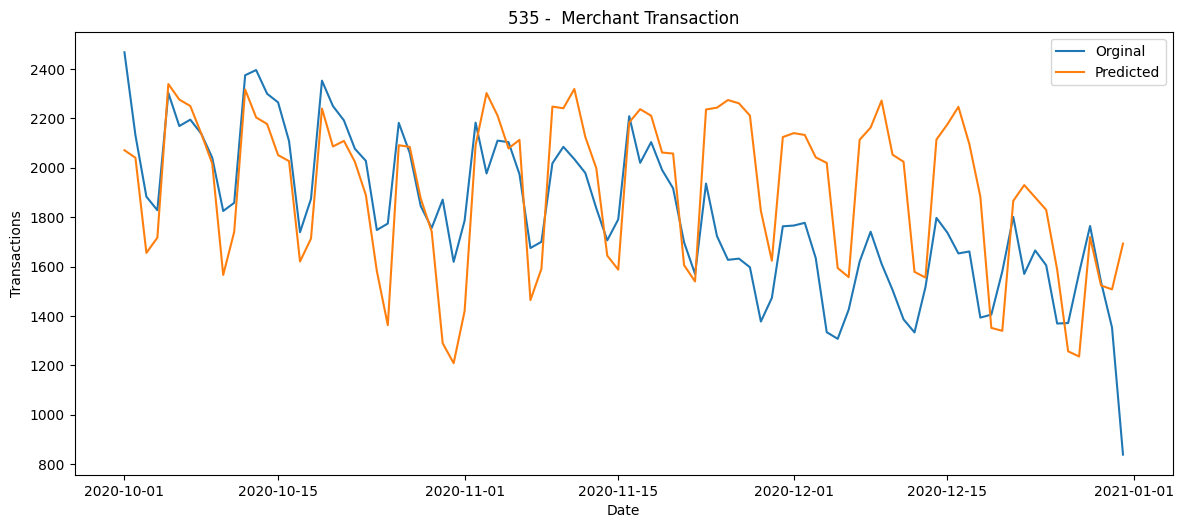

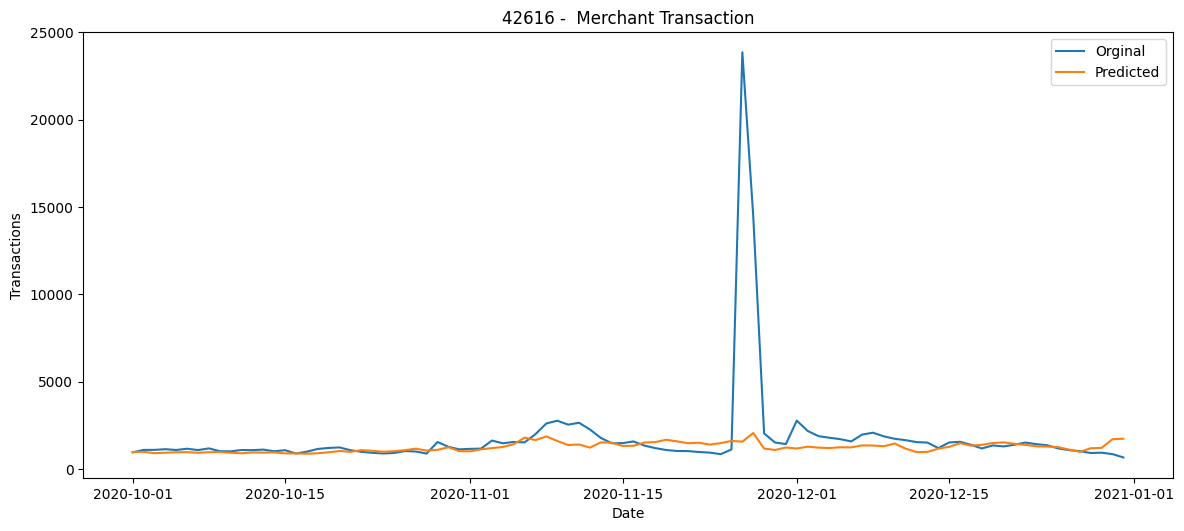

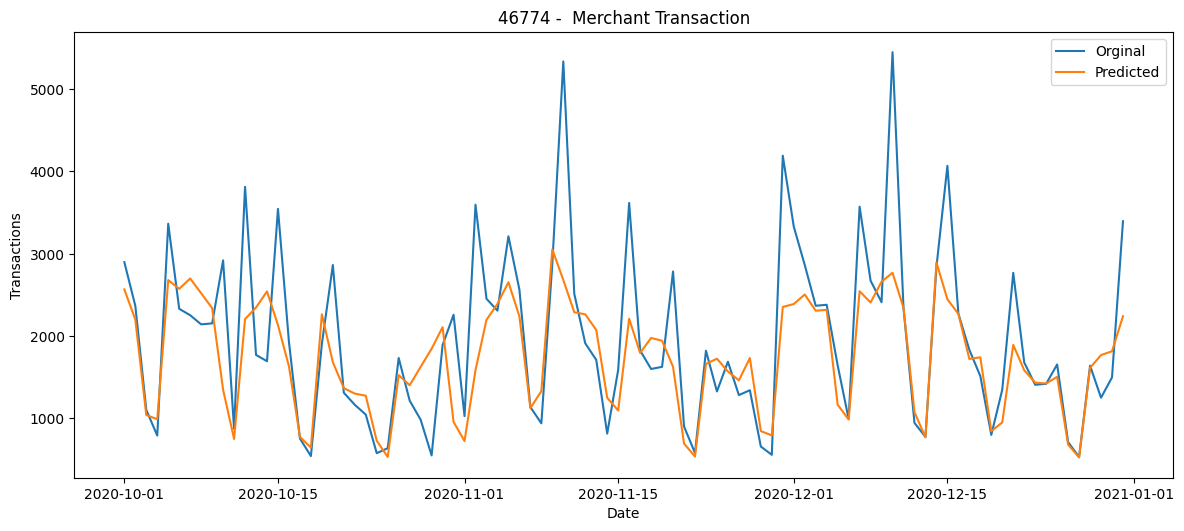

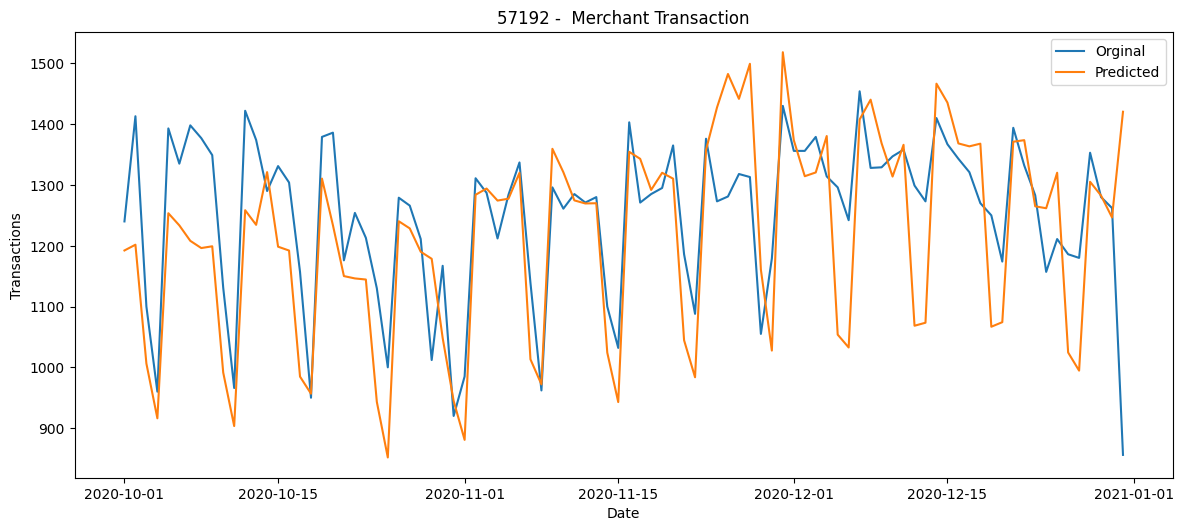

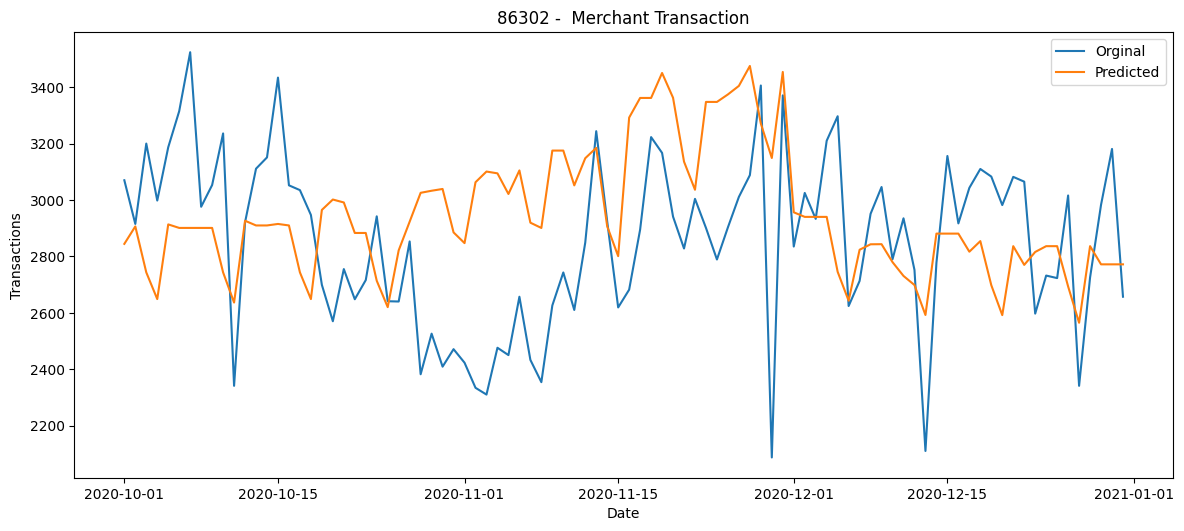

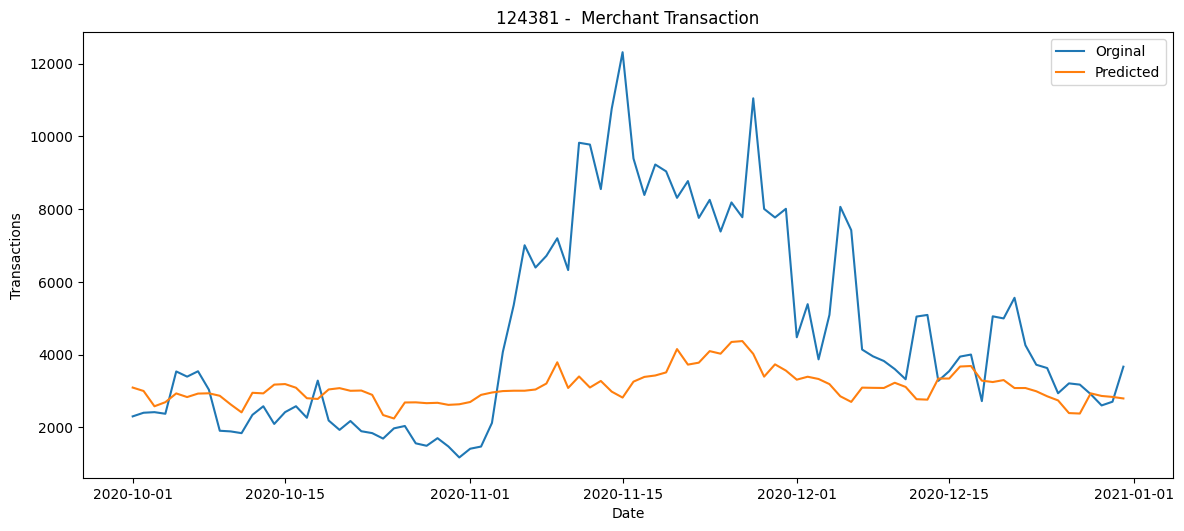

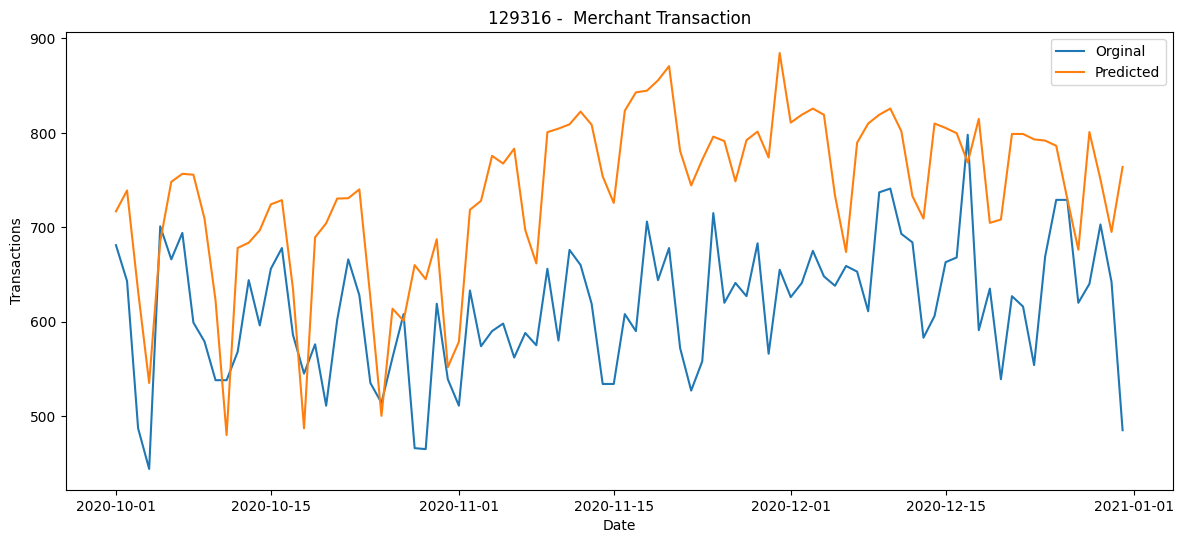

In [93]:
data = pd.read_csv("iyzico_data.csv", parse_dates=["transaction_date"])

train2 = data.loc[(data["transaction_date"]< "2020-10-01"), :]
val2 = data.loc[(data["transaction_date"] >= "2020-10-01"), :]
val2["val_pred"] = y_pred_val

def plot_pred_orginal(df, pred="val_pred"):
    for i, merchant in enumerate(df["merchant_id"].unique()):
        plt.figure(figsize=(12, 5 * len(df["merchant_id"].unique())))
        plt.subplot(len(df["merchant_id"].unique()), 1, i+1)
        masked_data = df[
            (df["merchant_id"] == merchant)
        ]
        plt.plot(masked_data["transaction_date"], masked_data["Total_Transaction"], label="Orginal")
        plt.plot(masked_data["transaction_date"], masked_data[pred], label="Predicted")
        plt.title(f"{merchant} -  Merchant Transaction")
        plt.xlabel('Date')
        plt.ylabel('Transactions')
        plt.tight_layout()
        plt.legend()
        plt.show()

plot_pred_orginal(val2, "val_pred")

## 8.3. Feature Importance

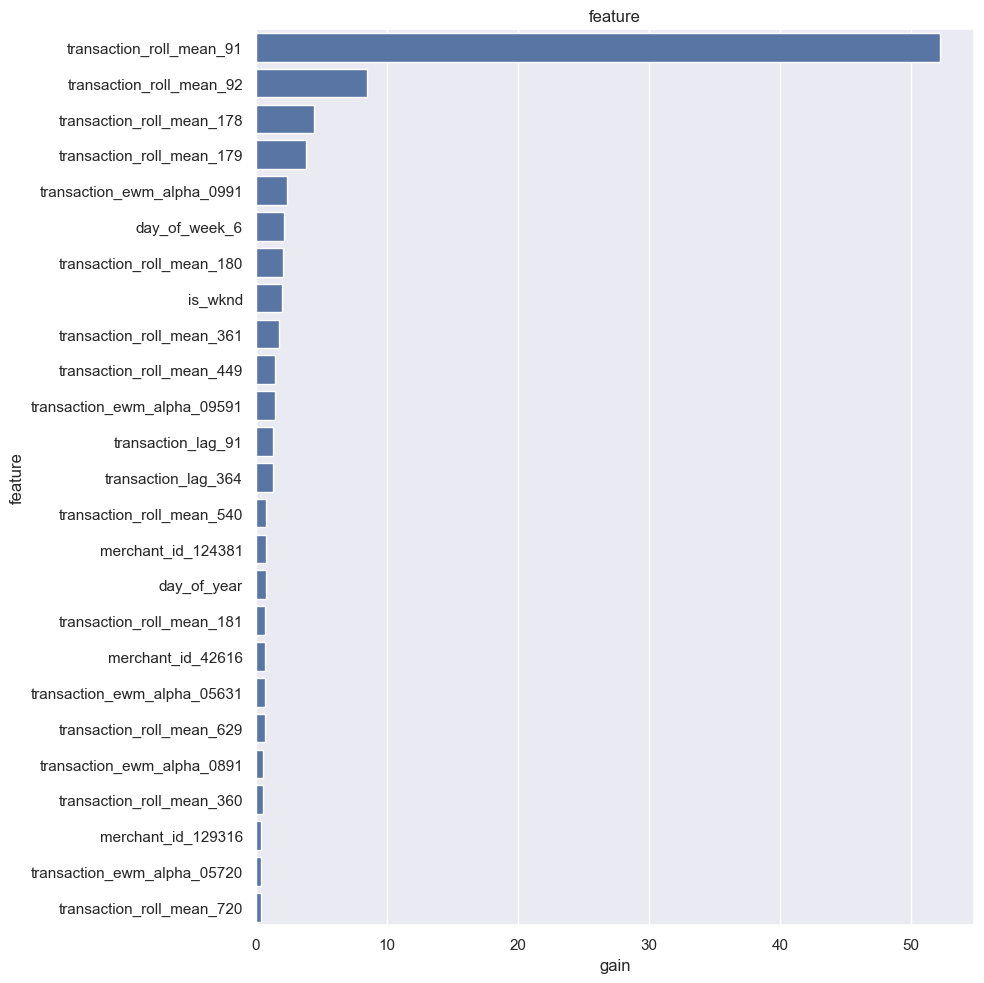

feature  split   gain
64       transaction_roll_mean_91    247 52.197
65       transaction_roll_mean_92    104  8.486
66      transaction_roll_mean_178     43  4.392
67      transaction_roll_mean_179     40  3.801
104    transaction_ewm_alpha_0991     34  2.380
201                 day_of_week_6     90  2.127
68      transaction_roll_mean_180     41  2.019
3                         is_wknd    133  1.966
73      transaction_roll_mean_361     26  1.738
74      transaction_roll_mean_449     30  1.443
84    transaction_ewm_alpha_09591     26  1.419
11             transaction_lag_91     34  1.296
47            transaction_lag_364    107  1.286
78      transaction_roll_mean_540     32  0.760
193            merchant_id_124381     44  0.741
1                     day_of_year    110  0.741
69      transaction_roll_mean_181     24  0.694
189             merchant_id_42616     89  0.671
182   transaction_ewm_alpha_05631     40  0.656
80      transaction_roll_mean_629     47  0.650
124    transaction_ewm_alpha_0891     12  0.503
72      transaction_roll_mean_360     19  0.490
194            merchant_id_129316     35  0.404
183   transaction_ewm_alpha_05720     34  0.388
83      transaction_roll_mean_720     57  0.360
79      transaction_roll_mean_541     34  0.334
0                    day_of_month     99  0.324
71      transaction_roll_mean_359     44  0.287
54            transaction_lag_538     38  0.274
40            transaction_lag_357     44  0.229
81      transaction_roll_mean_630     19  0.218
172   transaction_ewm_alpha_05360     20  0.210
178   transaction_ewm_alpha_05540     19  0.206
177   transaction_ewm_alpha_05539     14  0.204
110   transaction_ewm_alpha_09182     14  0.195
162   transaction_ewm_alpha_07631     12  0.192
70      transaction_roll_mean_182     24  0.189
190             merchant_id_46774     48  0.189
144    transaction_ewm_alpha_0791      9  0.181
48            transaction_lag_365     43  0.178
2                    week_of_year     28  0.174
9                   is_year_start     47  0.173
25            transaction_lag_182     33  0.170
179   transaction_ewm_alpha_05541     11  0.166
192             merchant_id_86302     28  0.157
77      transaction_roll_mean_539     27  0.155
59            transaction_lag_718     18  0.143
76      transaction_roll_mean_451     12  0.136
82      transaction_roll_mean_631     27  0.120
57            transaction_lag_541      5  0.117
63            transaction_lag_722     11  0.111
205                       month_4     19  0.111
53            transaction_lag_370     22  0.097
180   transaction_ewm_alpha_05629     12  0.094
200                 day_of_week_5      4  0.092
90   transaction_ewm_alpha_095182      7  0.091
100  transaction_ewm_alpha_095629      5  0.086
120   transaction_ewm_alpha_09629      2  0.085
181   transaction_ewm_alpha_05630     11  0.083
130   transaction_ewm_alpha_08182     11  0.081
75      transaction_roll_mean_450      7  0.075
139   transaction_ewm_alpha_08541      6  0.074
208                       month_7     19  0.068
39            transaction_lag_356     19  0.066
38            transaction_lag_355     20  0.063
125    transaction_ewm_alpha_0892      7  0.062
46            transaction_lag_363      7  0.057
173   transaction_ewm_alpha_05361     17  0.057
32            transaction_lag_189     17  0.056
35            transaction_lag_351     14  0.056
176   transaction_ewm_alpha_05451      6  0.055
33            transaction_lag_190     15  0.049
13            transaction_lag_170     26  0.047
60            transaction_lag_719     13  0.047
31            transaction_lag_188      7  0.047
138   transaction_ewm_alpha_08540     14  0.046
122   transaction_ewm_alpha_09631      2  0.046
29            transaction_lag_186     12  0.045
140   transaction_ewm_alpha_08629      3  0.043
34            transaction_lag_350      8  0.043
117   transaction_ewm_alpha_09539      8  0.042
142   transaction_ewm_alpha_08631      3  0.039
24            transaction_lag_181      8  

In [95]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance("gain")
    feat_imp = pd.DataFrame({"feature": model.feature_name(),
                            "split": model.feature_importance("split"),
                            "gain": 100 * gain / gain.sum()}).sort_values("gain", ascending=False)

    if plot:
        plt.figure(figsize = (10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title("feature")
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, plot=True, num=30)

## 9. Final Model

In [97]:
train = df.loc[(df["transaction_date"]< "2020-10-01"), :]
test = df.loc[(df["transaction_date"] >= "2020-10-01"), :]

cols = [col for col in train.columns if col not in ["transaction_date", "Total_Transaction", "Total_Paid", "year"]]

Y_train = train["Total_Transaction"]
X_train = train[cols]

Y_test = val["Total_Transaction"]
X_test = val[cols]

Y_train.shape, X_train.shape, Y_test.shape, X_test.shape

((7023,), (7023, 214), (644,), (644, 214))

In [99]:
# Let's remove the variables with a gain value of 0:

feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

impt_feats = [col for col in cols if col not in importance_zero]

X_train=X_train[impt_feats]
X_test=X_test[impt_feats]

                          feature  split   gain
64       transaction_roll_mean_91    247 52.197
65       transaction_roll_mean_92    104  8.486
66      transaction_roll_mean_178     43  4.392
67      transaction_roll_mean_179     40  3.801
104    transaction_ewm_alpha_0991     34  2.380
201                 day_of_week_6     90  2.127
68      transaction_roll_mean_180     41  2.019
3                         is_wknd    133  1.966
73      transaction_roll_mean_361     26  1.738
74      transaction_roll_mean_449     30  1.443
84    transaction_ewm_alpha_09591     26  1.419
11             transaction_lag_91     34  1.296
47            transaction_lag_364    107  1.286
78      transaction_roll_mean_540     32  0.760
193            merchant_id_124381     44  0.741
1                     day_of_year    110  0.741
69      transaction_roll_mean_181     24  0.694
189             merchant_id_42616     89  0.671
182   transaction_ewm_alpha_05631     40  0.656
80      transaction_roll_mean_629     47

In [101]:
best_params

{'num_leaves': 73,
 'learning_rate': 0.024216038680394618,
 'feature_fraction': 0.7150470881008266,
 'max_depth': 4,
 'metric': {'mae'},
 'objective': 'regression',
 'boosting_type': 'gbdt',
 'verbosity': -1,
 'nthread': -1,
 'early_stopping_rounds': 200,
 'num_boost_round': 5000}

In [111]:
test2 = data.loc[(data["transaction_date"] >= "2020-10-01"), :]
lgb_params = {"num_leaves": 73,
             "learning_rate": 0.024216038680394618,
             "feature_fraction": 0.7150470881008266,
             "max_depth": 4,
             "verbose": -1,
             "nthread": -1,
             "num_boost_round": best_iteration}

lgbtrain_all = lgb.Dataset(data = X_train, label = Y_train, feature_name=impt_feats)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=lgb_params["num_boost_round"])

test_preds = final_model.predict(X_test, num_iteration=lgb_params["num_boost_round"])

test_preds = np.expm1(test_preds)

test2["test_pred"] = test_preds

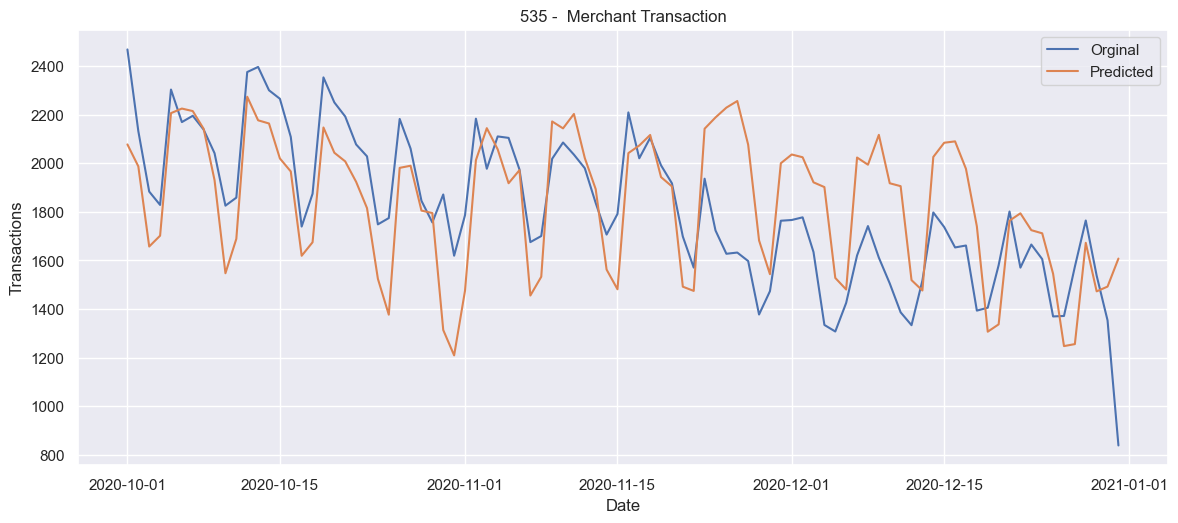

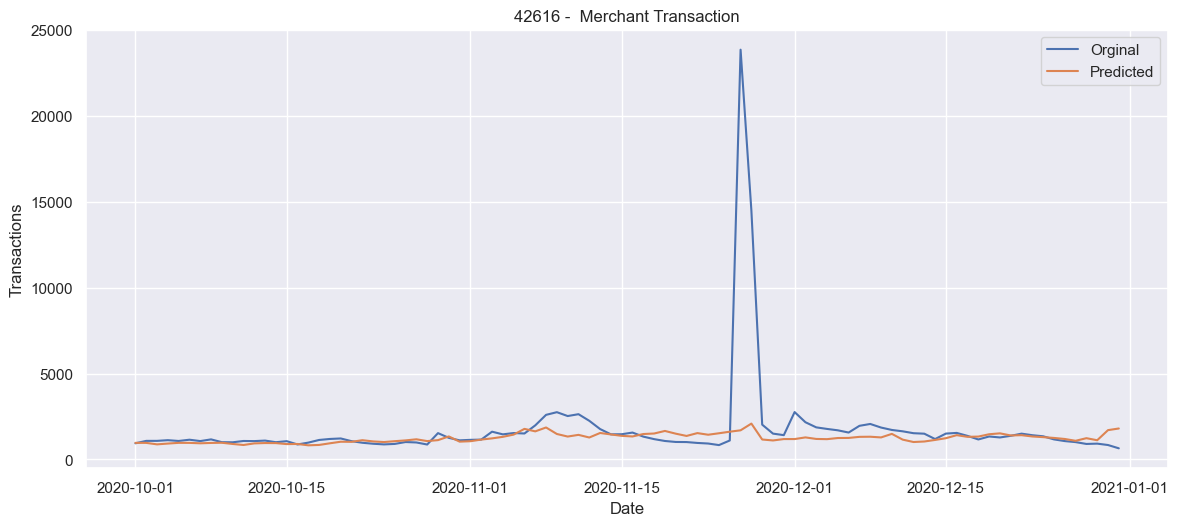

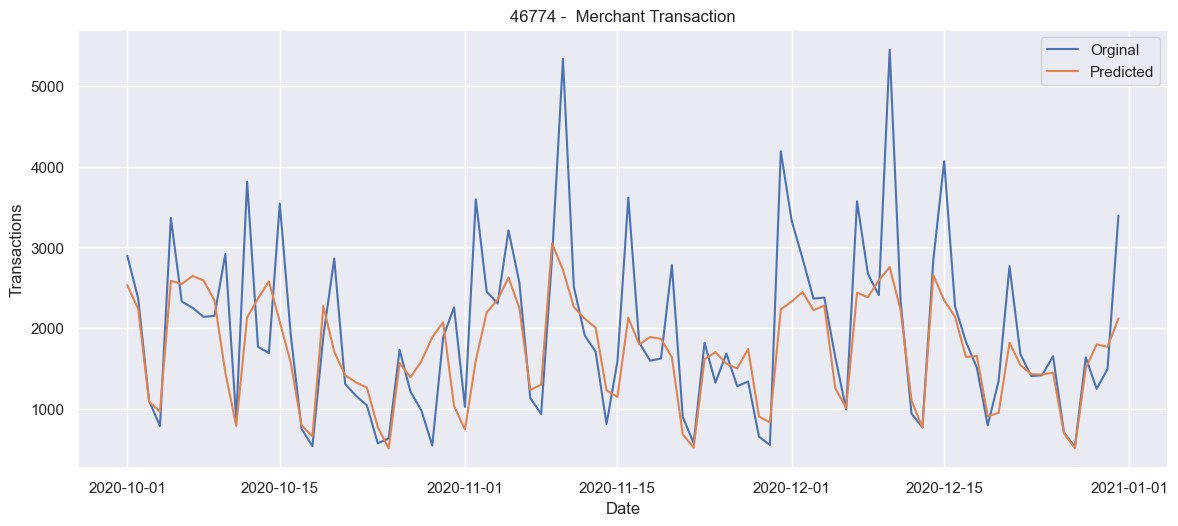

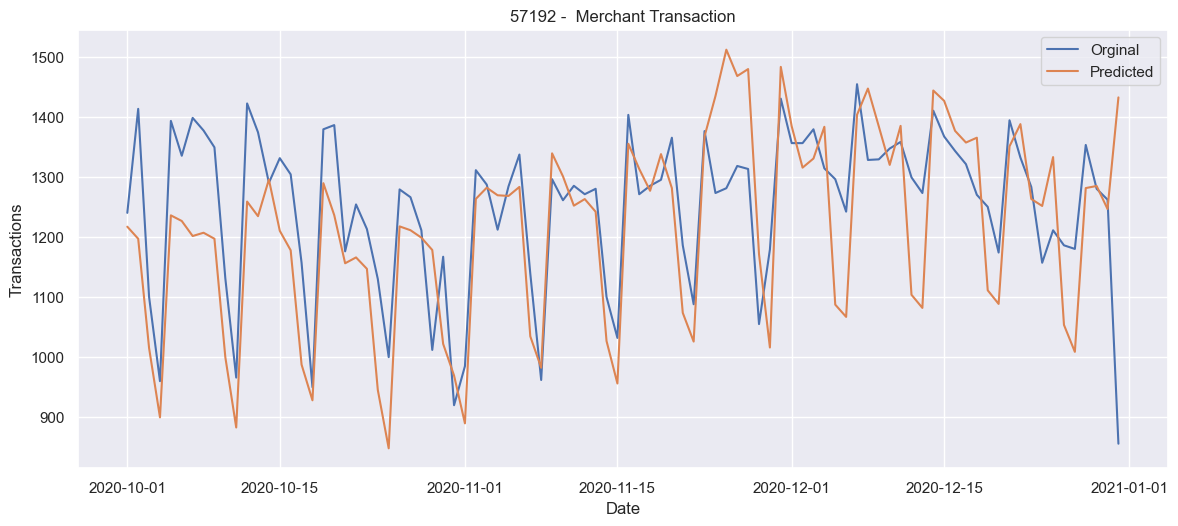

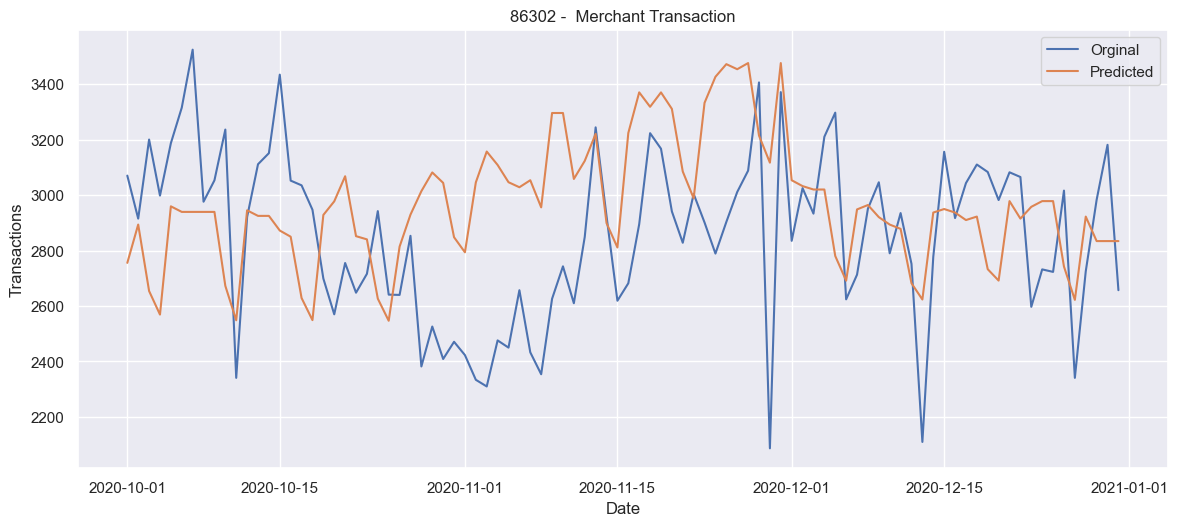

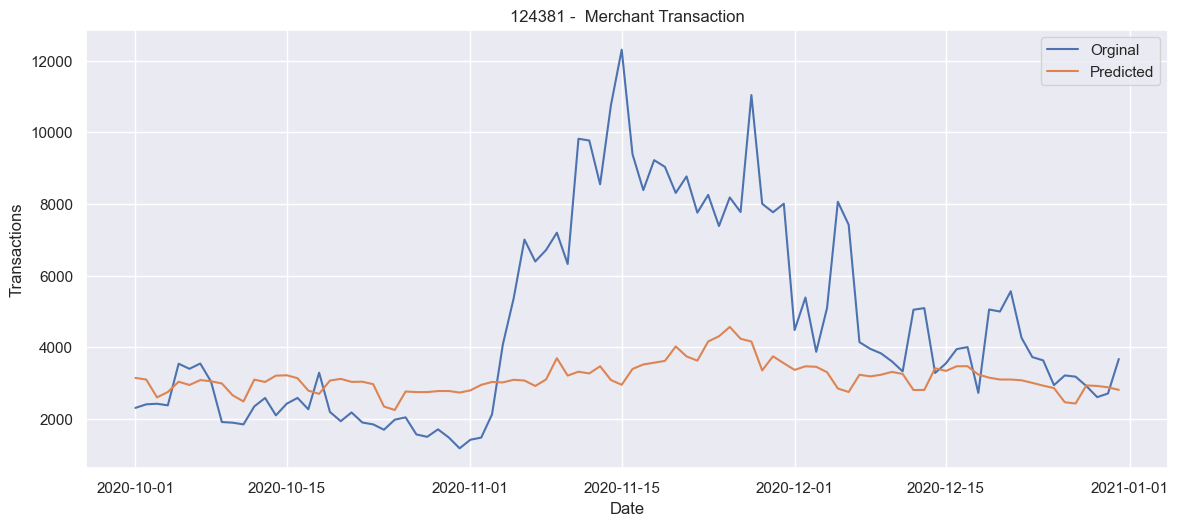

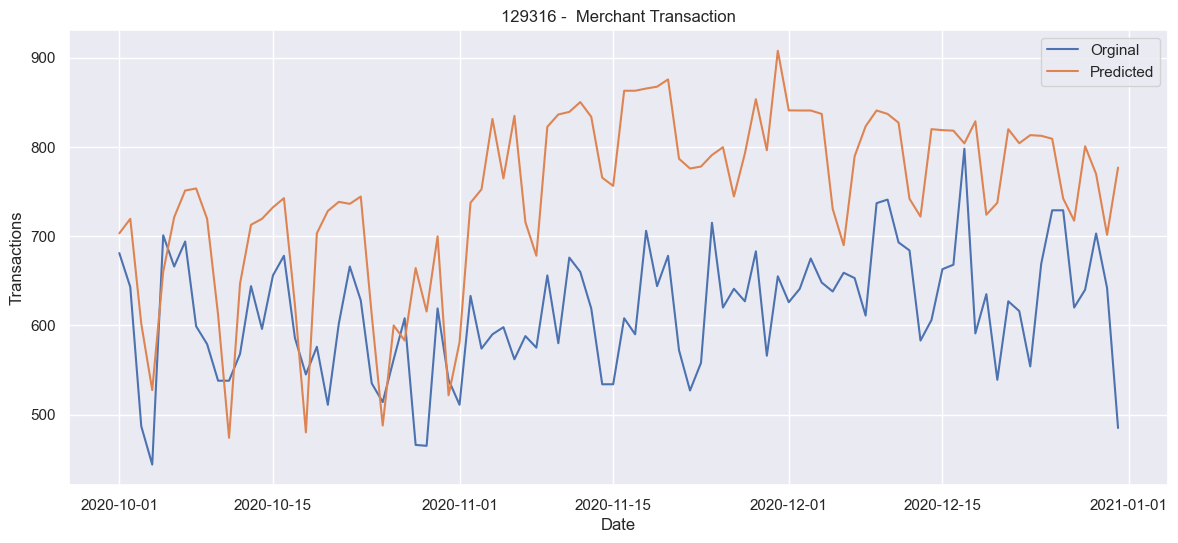

In [113]:
plot_pred_orginal(test2, "test_pred")